# Fashion-MNIST | Single Layer Bilinear Model
This notebook trains the model and generates the figures for the paper "Weight-based Decomposition: A Case for Bilinear MLPs"

# Setup

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install einops
!pip install jaxtyping
!git clone https://github.com/tdooms/bilinear-interp.git
# !pip install git+https://github.com/2020leon/rpca.git


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 1.0 MB/s eta 0:00:00
Cloning into 'bilinear-interp'...
remote: Enumerating objects: 1244, done.
remote: Counting objects: 100% (502/502), done.
remote: Compressing objects: 100% (250/250), done.
remote: Total 1244 (delta 275), reused 455 (delta 243), pack-reused 742
Receiving objects: 100% (1244/1244), 214.35 MiB | 14.53 MiB/s, done.
Resolving deltas: 100% (688/688), done.


In [ ]:
%cd /content/bilinear-interp

/content/bilinear-interp


In [ ]:
# !git pull

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import itertools
import einops
from collections import defaultdict

from mnist.model import *
from mnist.utils import *
from mnist.plotting import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load Data

In [ ]:
# Import Fashion MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.FashionMNIST(root='./data',
                                          train=False,
                                          transform=transforms.ToTensor())

In [ ]:
# Data loader
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

DATA_CLASSES = ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

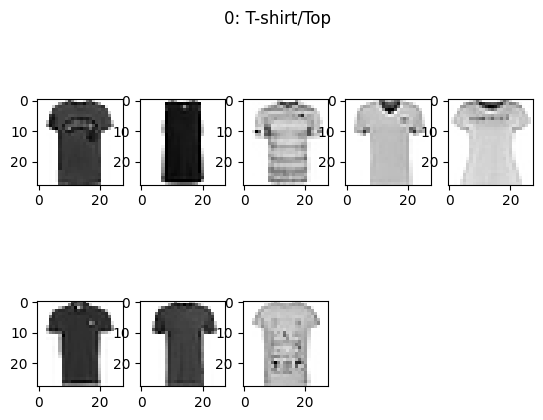

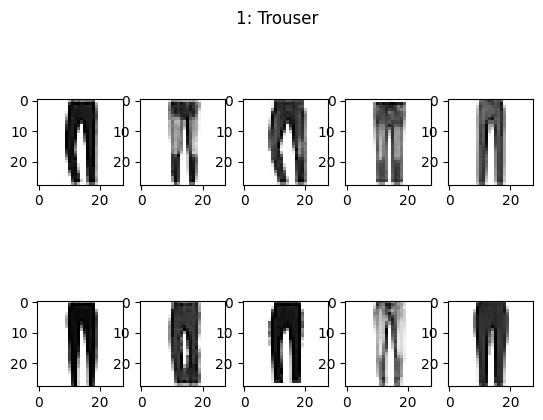

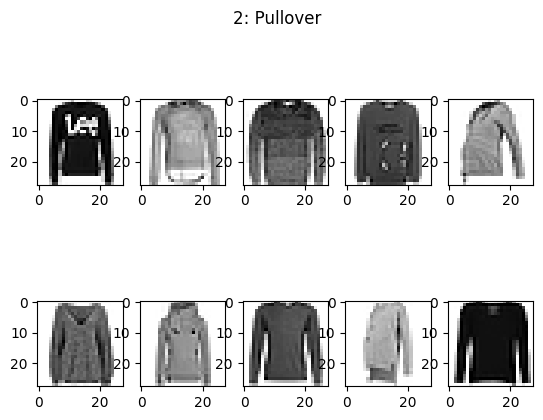

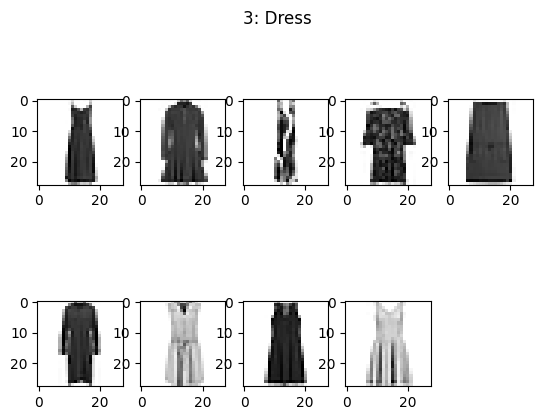

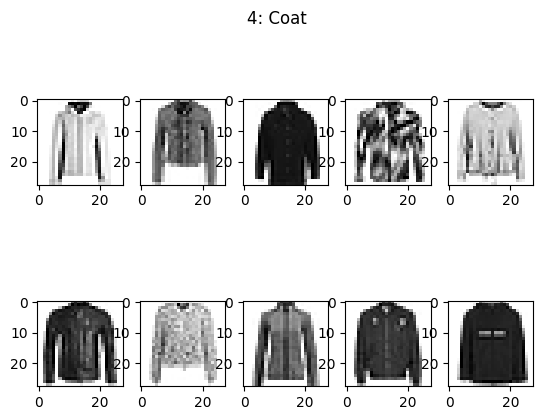

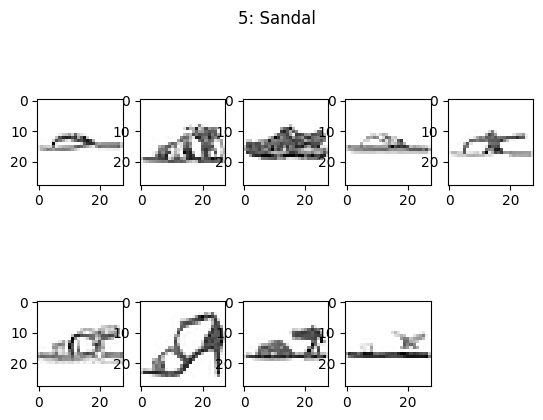

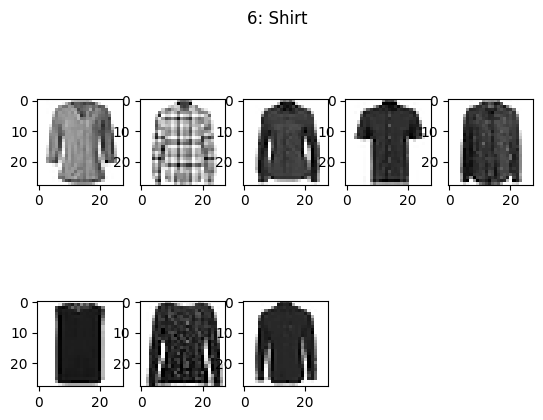

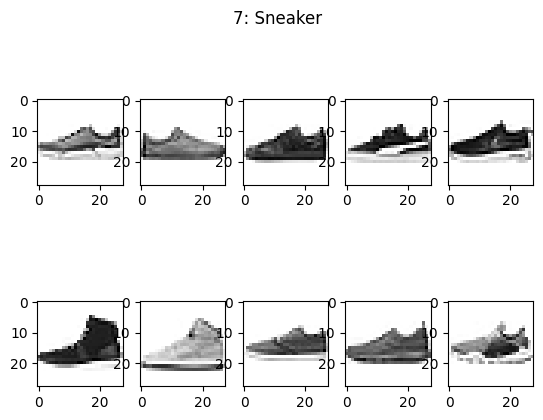

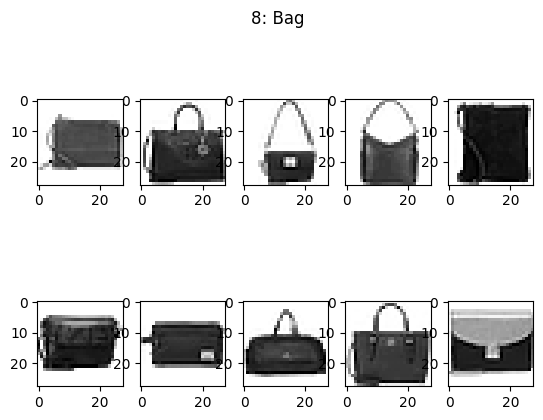

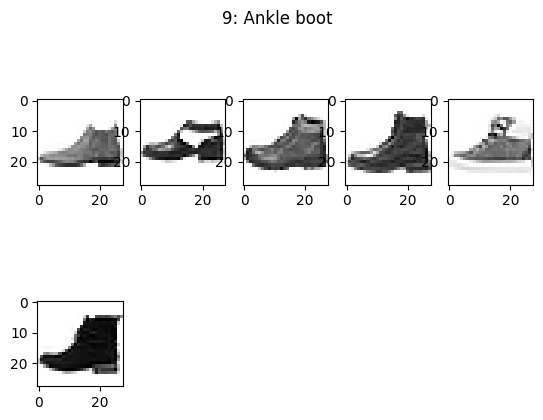

In [ ]:
examples = iter(test_loader)
example_data, example_targets = next(examples)

for label in range(10):
    plt.figure()
    mask = example_targets == label
    data = example_data[mask]
    num = min(data.shape[0],10)
    for i in range(num):
        plt.subplot(2,5,i+1)
        plt.imshow(data[i][0], cmap='binary')
    plt.suptitle(f'{label}: {DATA_CLASSES[label]}')
    plt.show()

# Train Model

In [ ]:
cfg = MnistConfig()
cfg.random_seed = 0
cfg.n_layers = 1
cfg.hidden_dim = 300
cfg.num_epochs = 2 + 10 + 40
cfg.lr = 0.001
cfg.lr_decay = 0.5
cfg.lr_decay_step = 2
cfg.weight_decay = 1
cfg.rms_norm = False
cfg.bias = False
cfg.noise_sparse = 0
cfg.noise_dense = 0.33
cfg.layer_noise = 0.33

model = MnistModel(cfg).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
linearLR = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, end_factor=1, total_iters = 2)
stepLR = torch.optim.lr_scheduler.StepLR(optimizer, step_size=cfg.lr_decay_step, gamma=cfg.lr_decay)
constLR = torch.optim.lr_scheduler.ConstantLR(optimizer, factor = cfg.lr_decay**(10/cfg.lr_decay_step), total_iters = 1000)
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[linearLR, stepLR, constLR], milestones=[2, 13])

model.train(train_loader, test_loader, optimizer = optimizer, scheduler = scheduler)

Accuracy on validation set: 10.95 %
Epoch [1/52], Step [100/600], Loss: 2.2230
Epoch [1/52], Step [200/600], Loss: 1.9921
Epoch [1/52], Step [300/600], Loss: 1.7368
Epoch [1/52], Step [400/600], Loss: 1.4944
Epoch [1/52], Step [500/600], Loss: 1.3420
Epoch [1/52], Step [600/600], Loss: 1.1031
learning rate = 0.000505
Accuracy on validation set: 65.82 %
Epoch [2/52], Step [100/600], Loss: 0.6862
Epoch [2/52], Step [200/600], Loss: 0.7619
Epoch [2/52], Step [300/600], Loss: 0.5903
Epoch [2/52], Step [400/600], Loss: 0.5162
Epoch [2/52], Step [500/600], Loss: 0.5363
Epoch [2/52], Step [600/600], Loss: 0.5808
learning rate = 0.001
Accuracy on validation set: 80.79 %
Epoch [3/52], Step [100/600], Loss: 0.5401
Epoch [3/52], Step [200/600], Loss: 0.6858
Epoch [3/52], Step [300/600], Loss: 0.5669
Epoch [3/52], Step [400/600], Loss: 0.6730
Epoch [3/52], Step [500/600], Loss: 0.5405
Epoch [3/52], Step [600/600], Loss: 0.5927
learning rate = 0.001
Accuracy on validation set: 81.89 %
Epoch [4/52],

## Save model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pickle

Mounted at /content/drive


In [ ]:
filename = '/content/drive/MyDrive/AI Alignment/Codebooks_In_Superposition/deep_bilinear_model_with_biases_(test).pkl'
with open(filename, 'wb') as f:
  pickle.dump(model, f)

## Load model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pickle

Mounted at /content/drive


In [ ]:
filename = '/content/drive/MyDrive/AI Alignment/Codebooks_In_Superposition/deep_bilinear_model_with_biases_(test).pkl'
with open(filename, 'rb') as f:
  model = pickle.load(f)

# Eigendecomposition

In [ ]:
W = model.layers[0].linear1.weight.to("cpu").detach()
V = model.layers[0].linear2.weight.to("cpu").detach()
W_out = model.linear_out.weight.to("cpu").detach()
W_in = model.linear_in.weight.to("cpu").detach()
B = get_B_tensor(W, V)
B = einops.rearrange(B, "out (in1 in2) -> out in1 in2", in1 = model.cfg.d_hidden)

B_proj = einops.einsum(W_out, B, "class h2, h2 in1 in2-> class in1 in2")

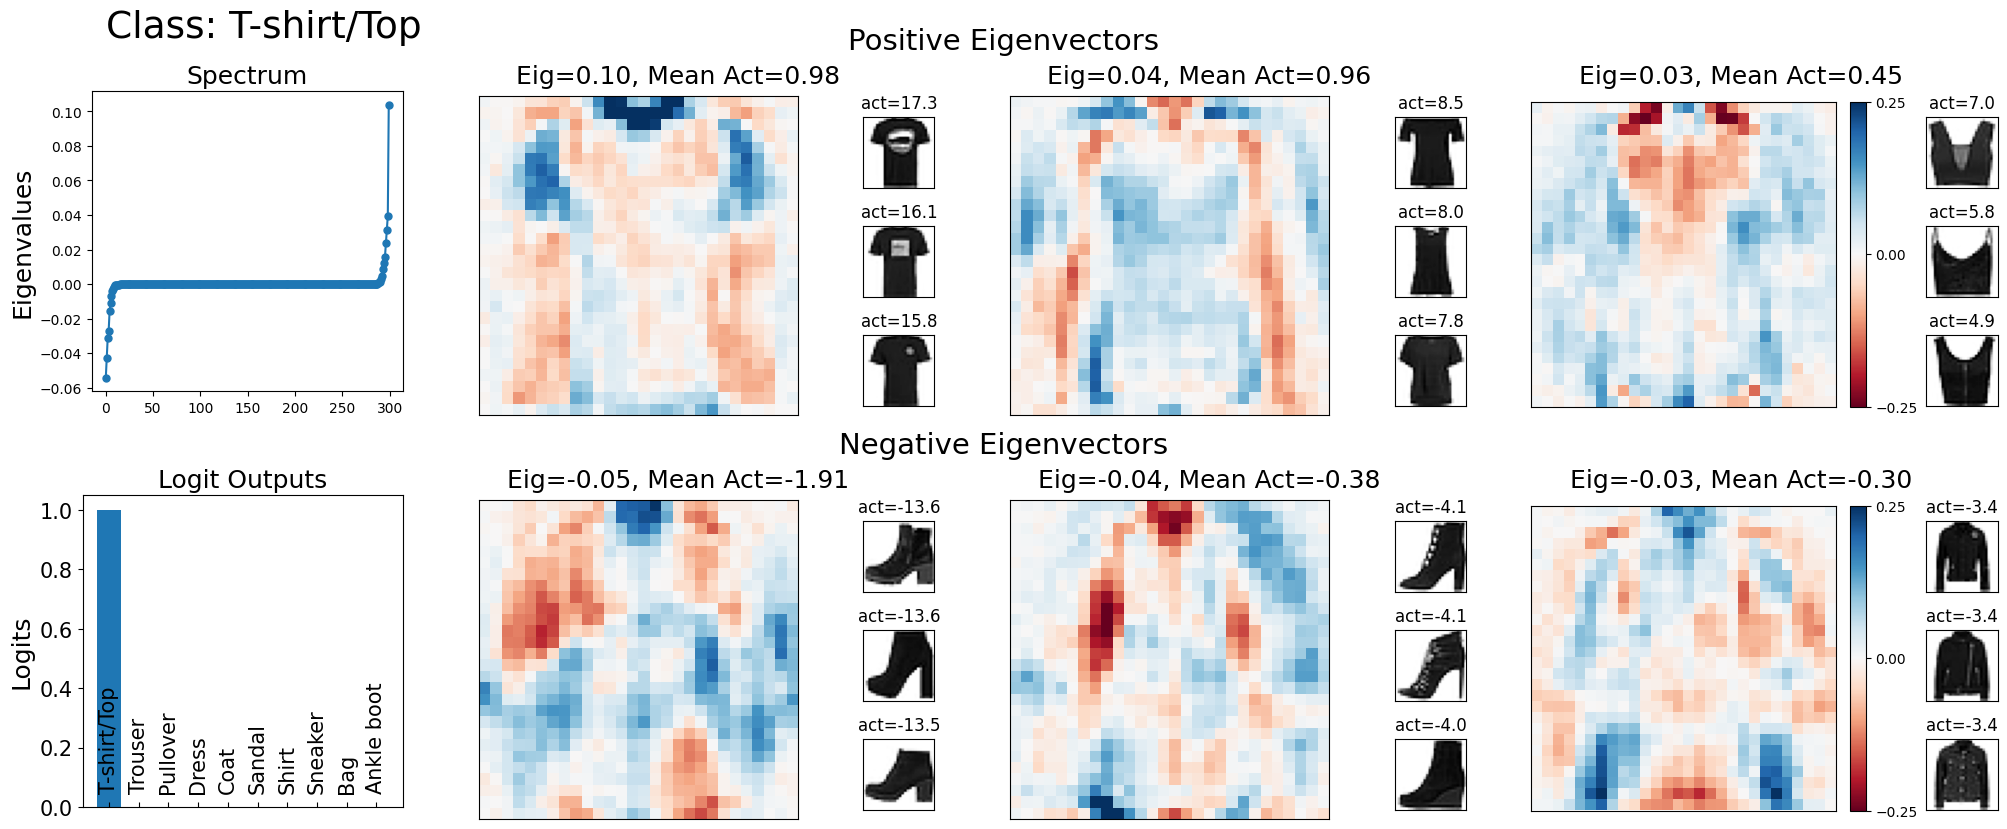

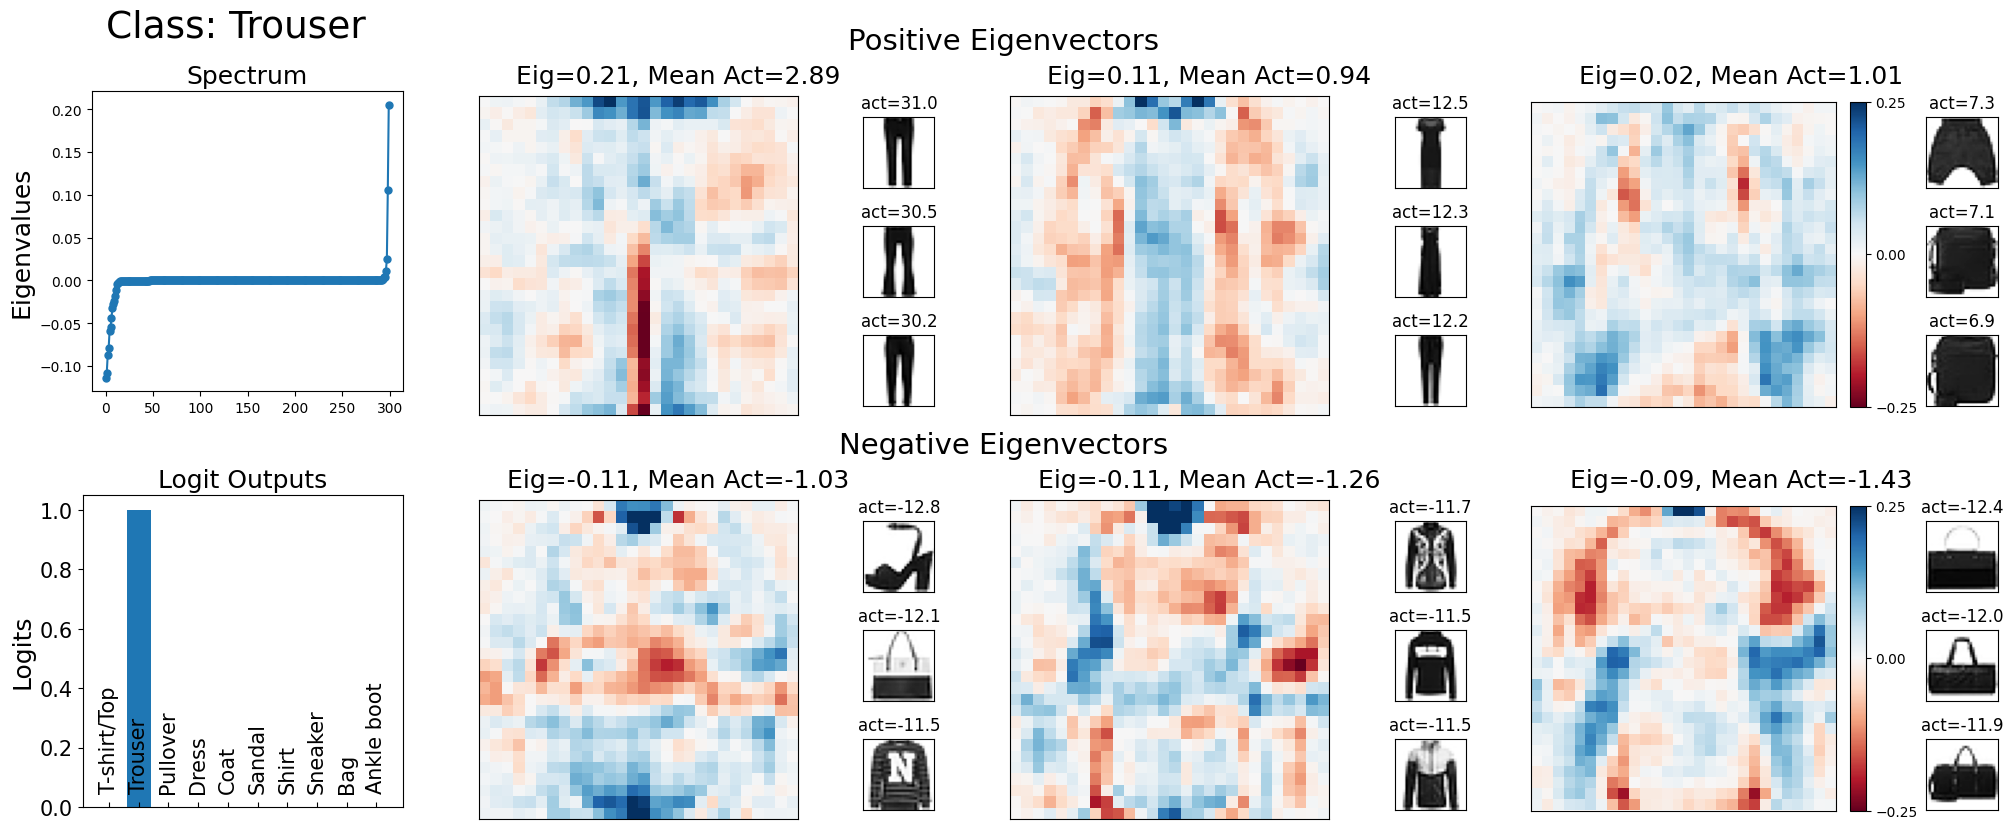

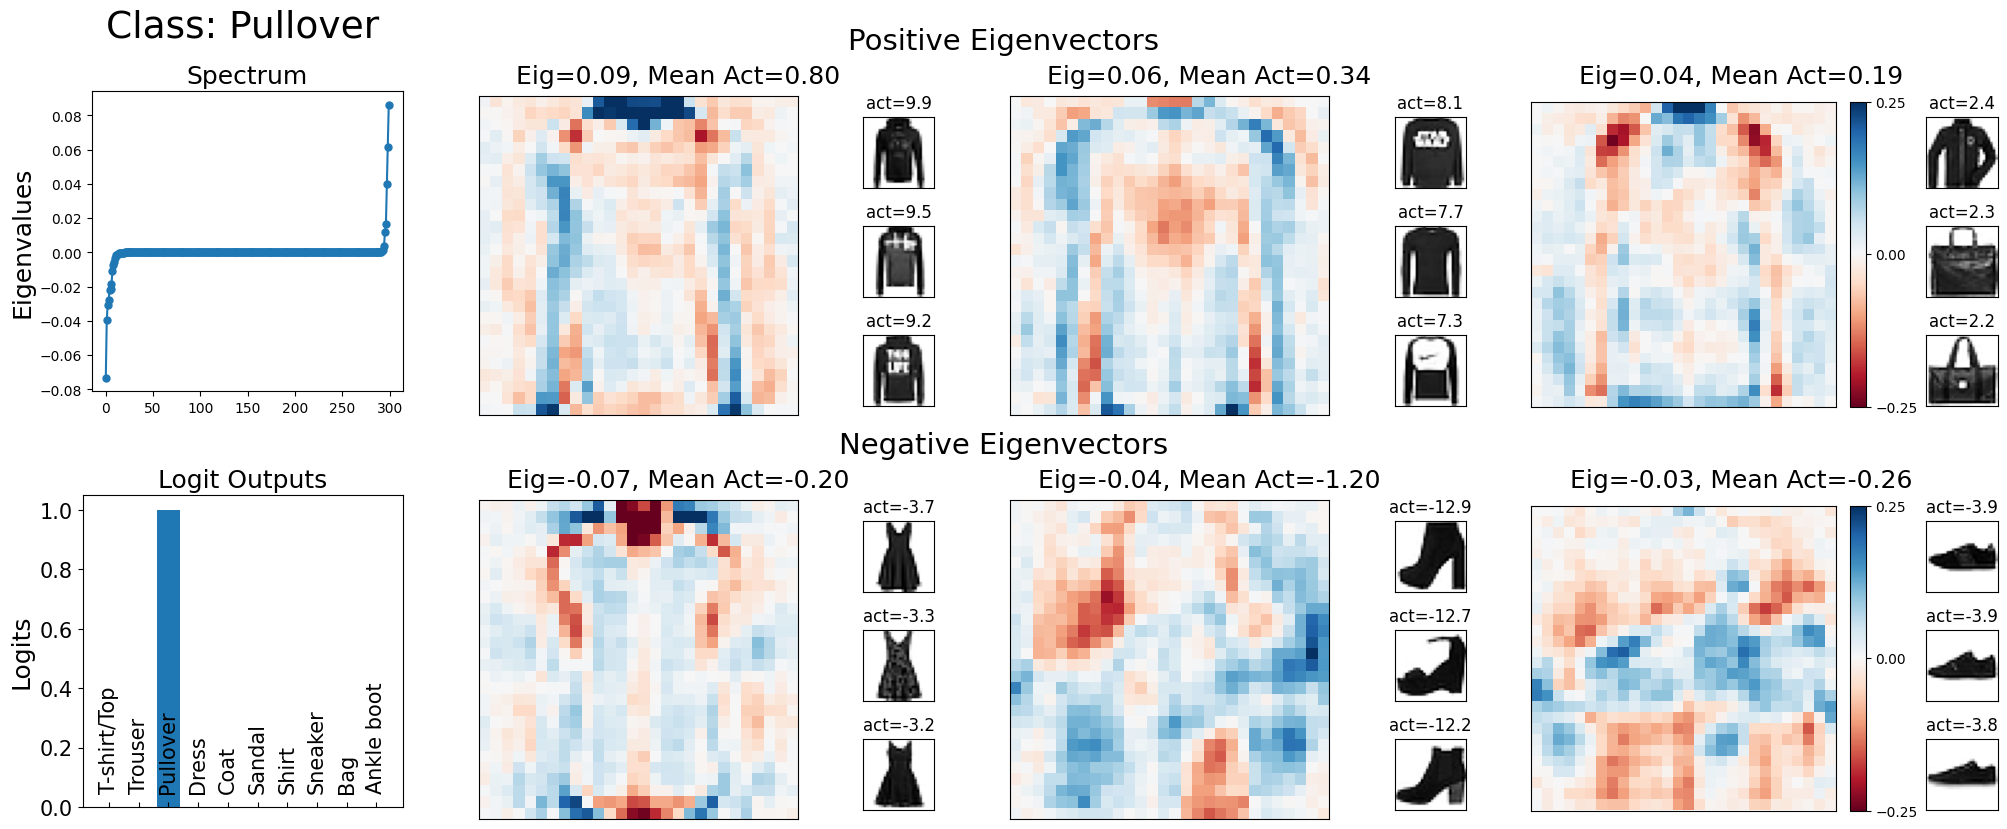

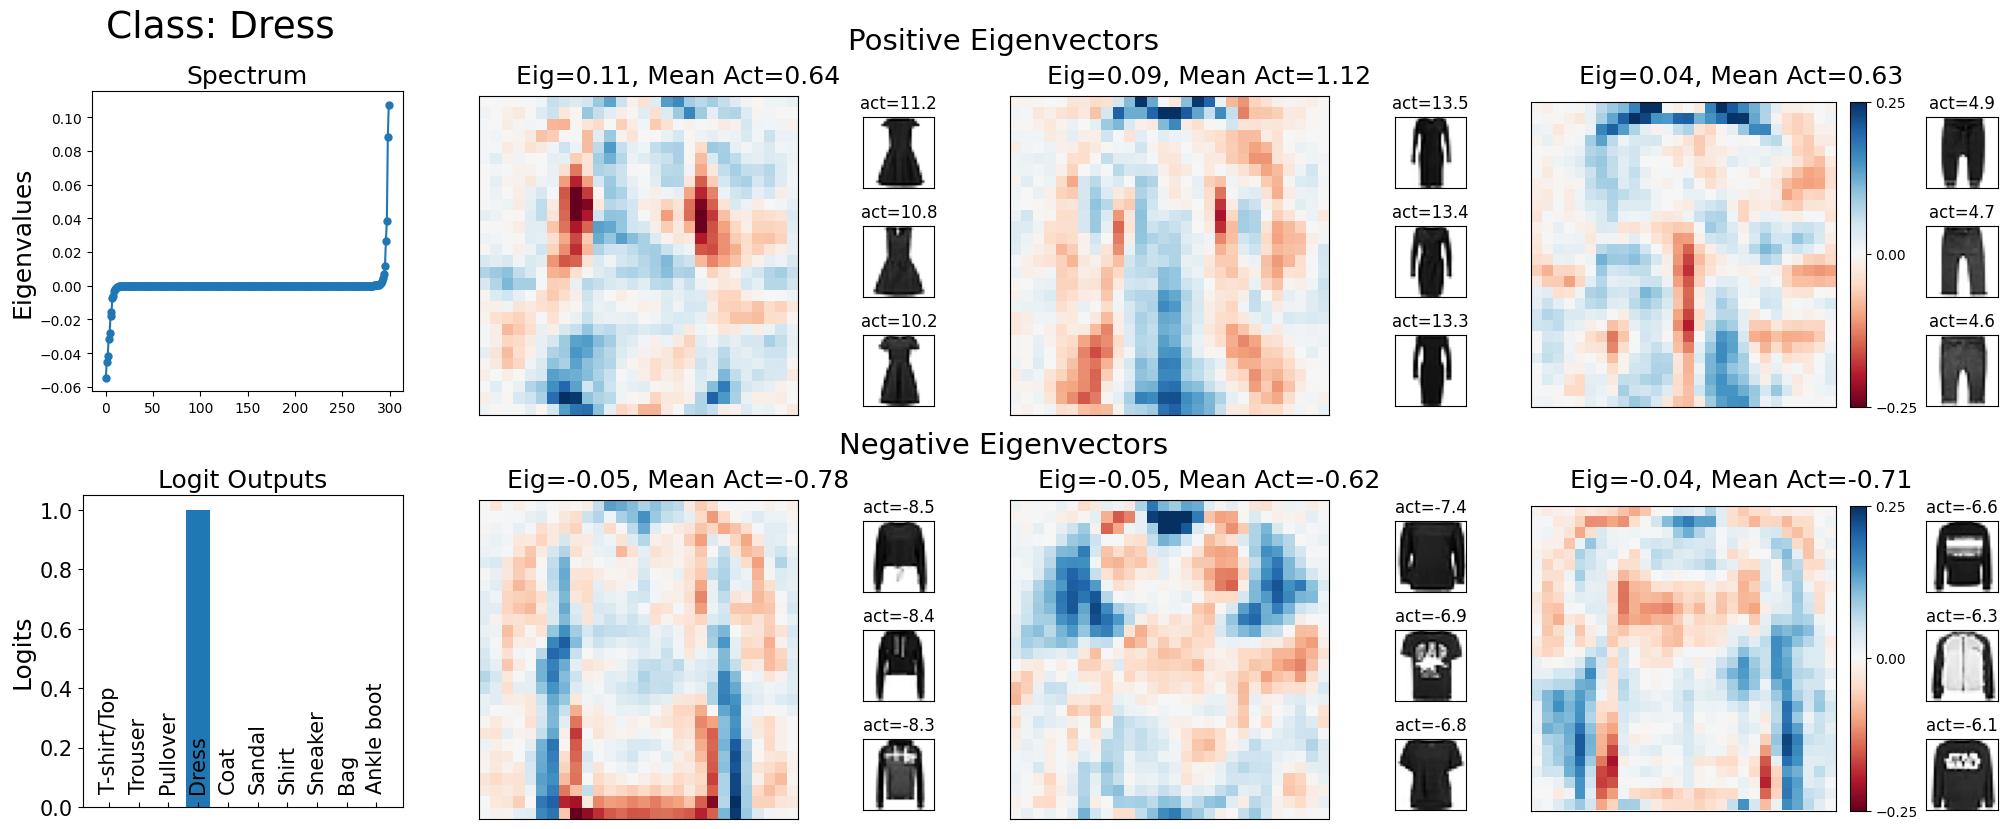

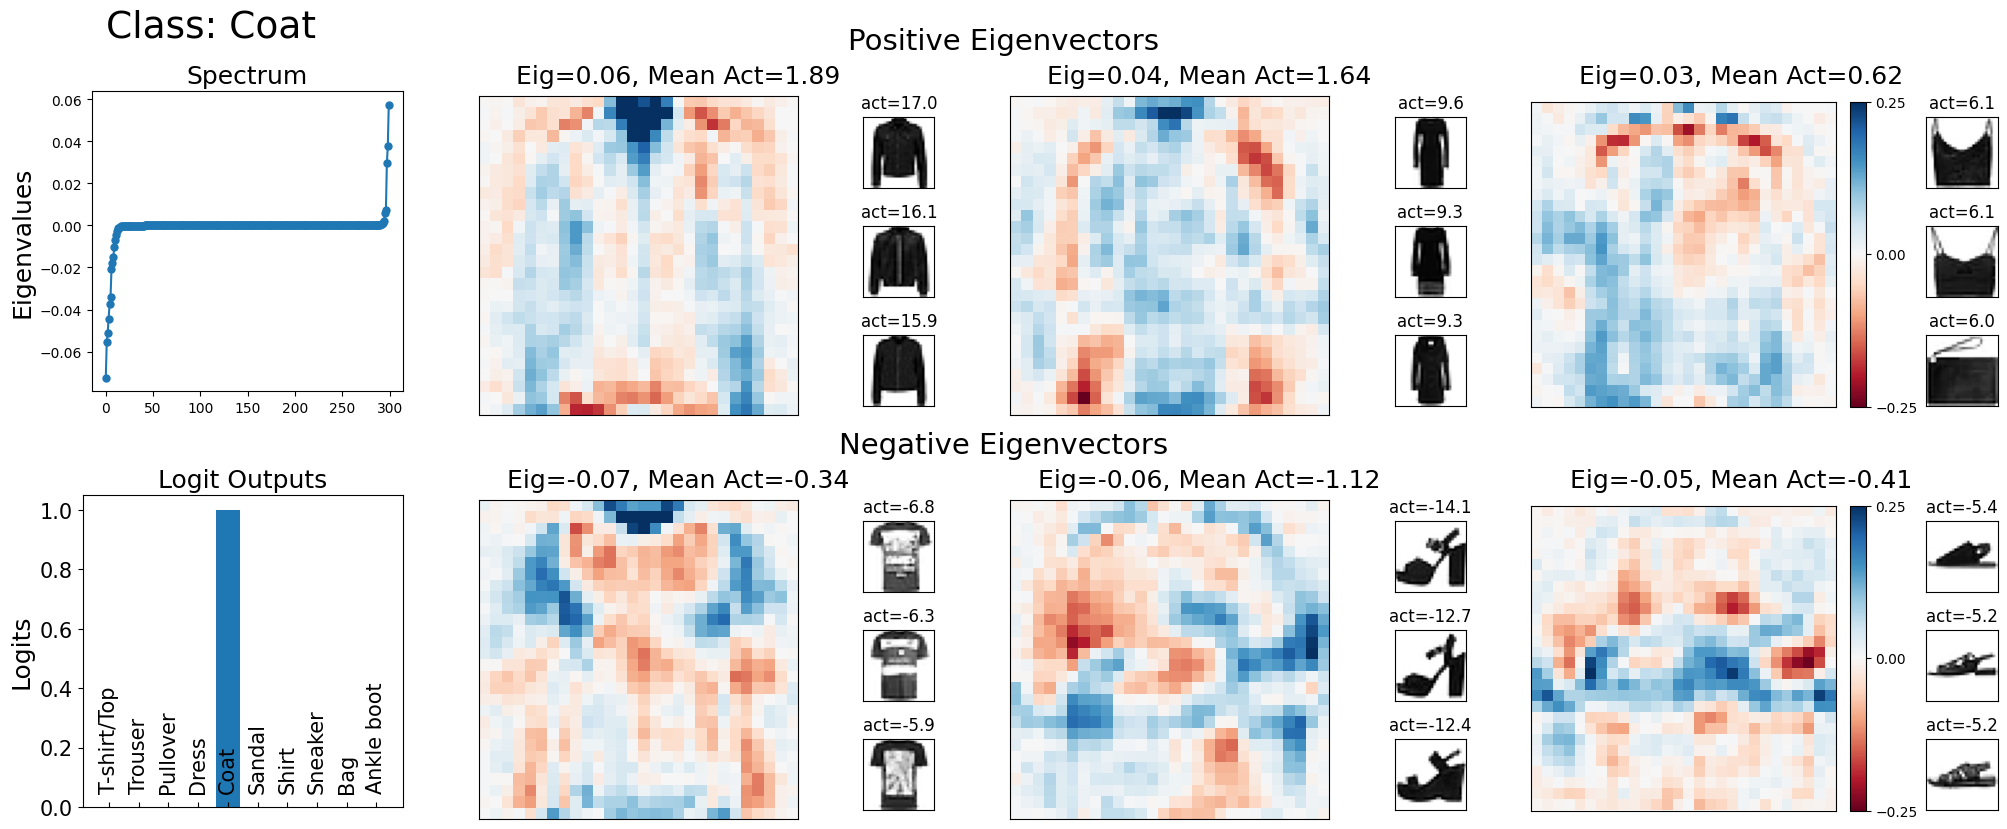

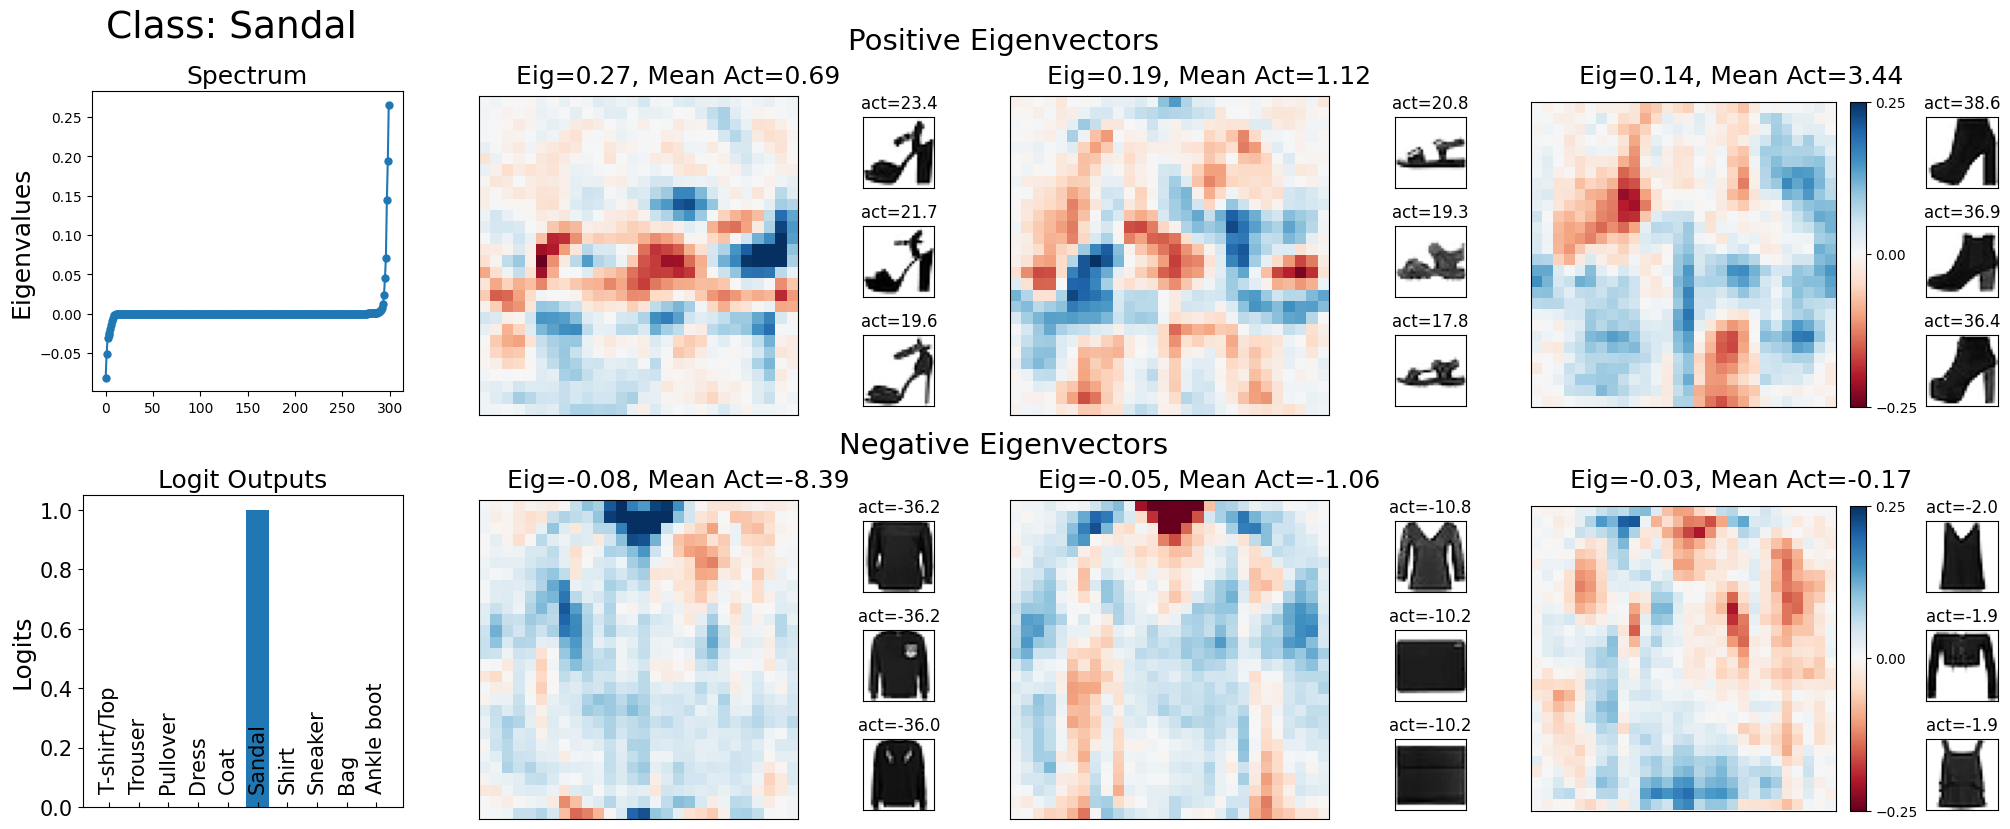

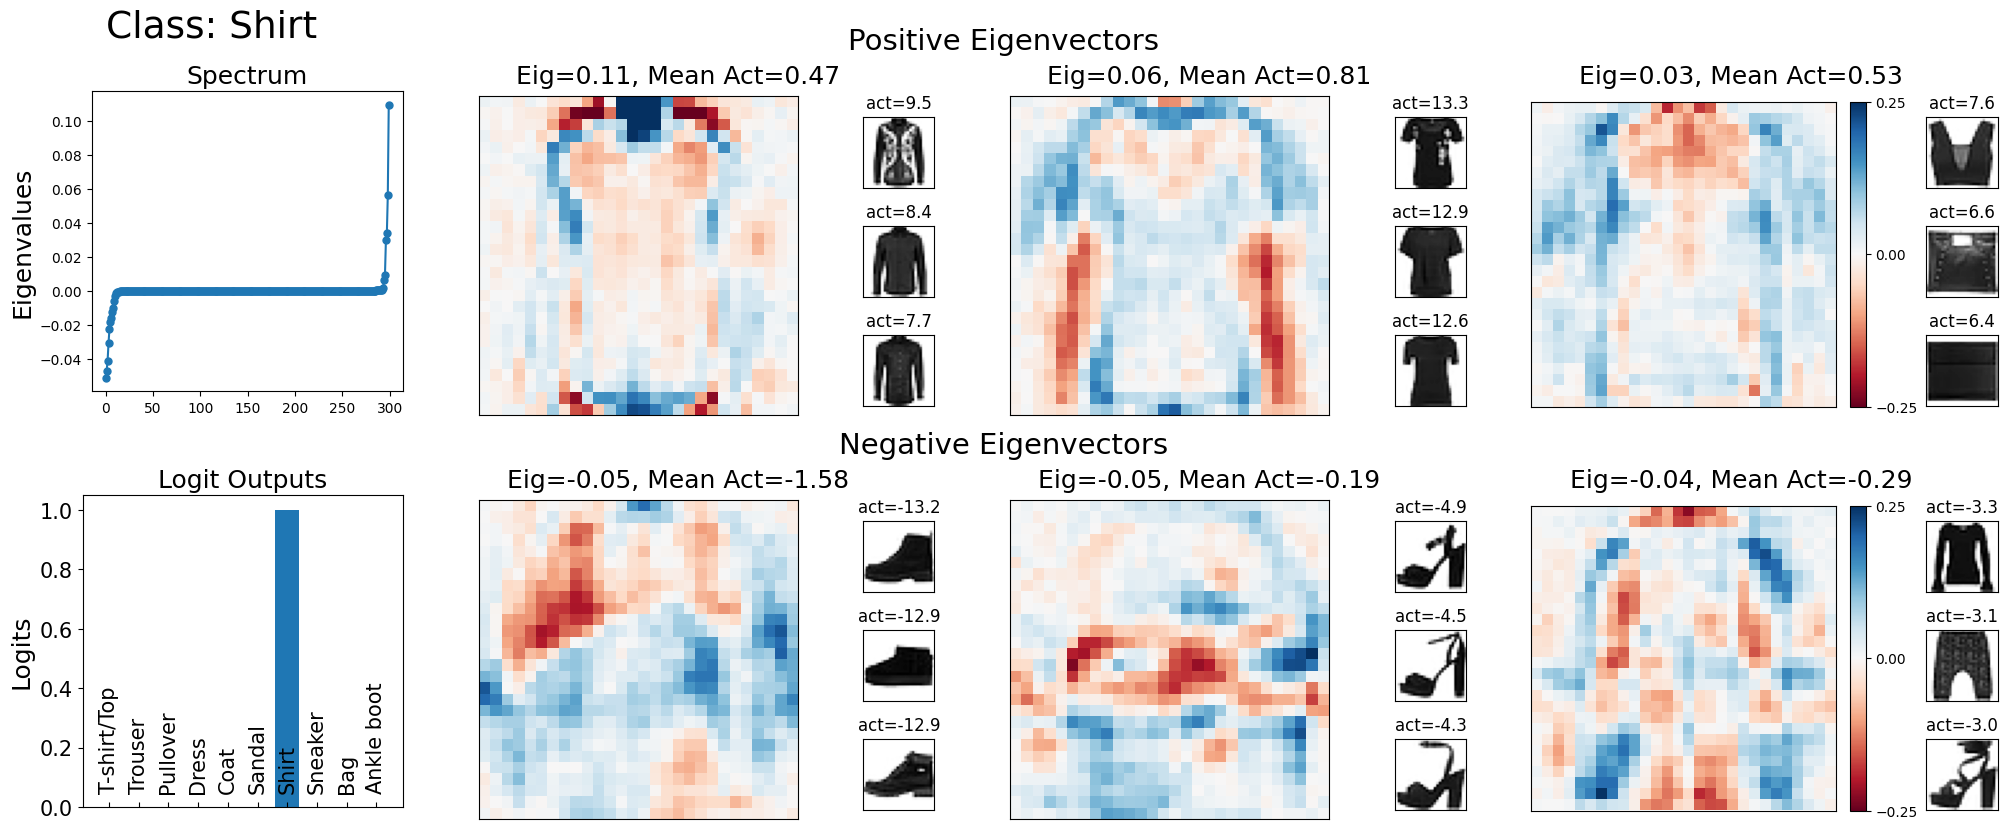

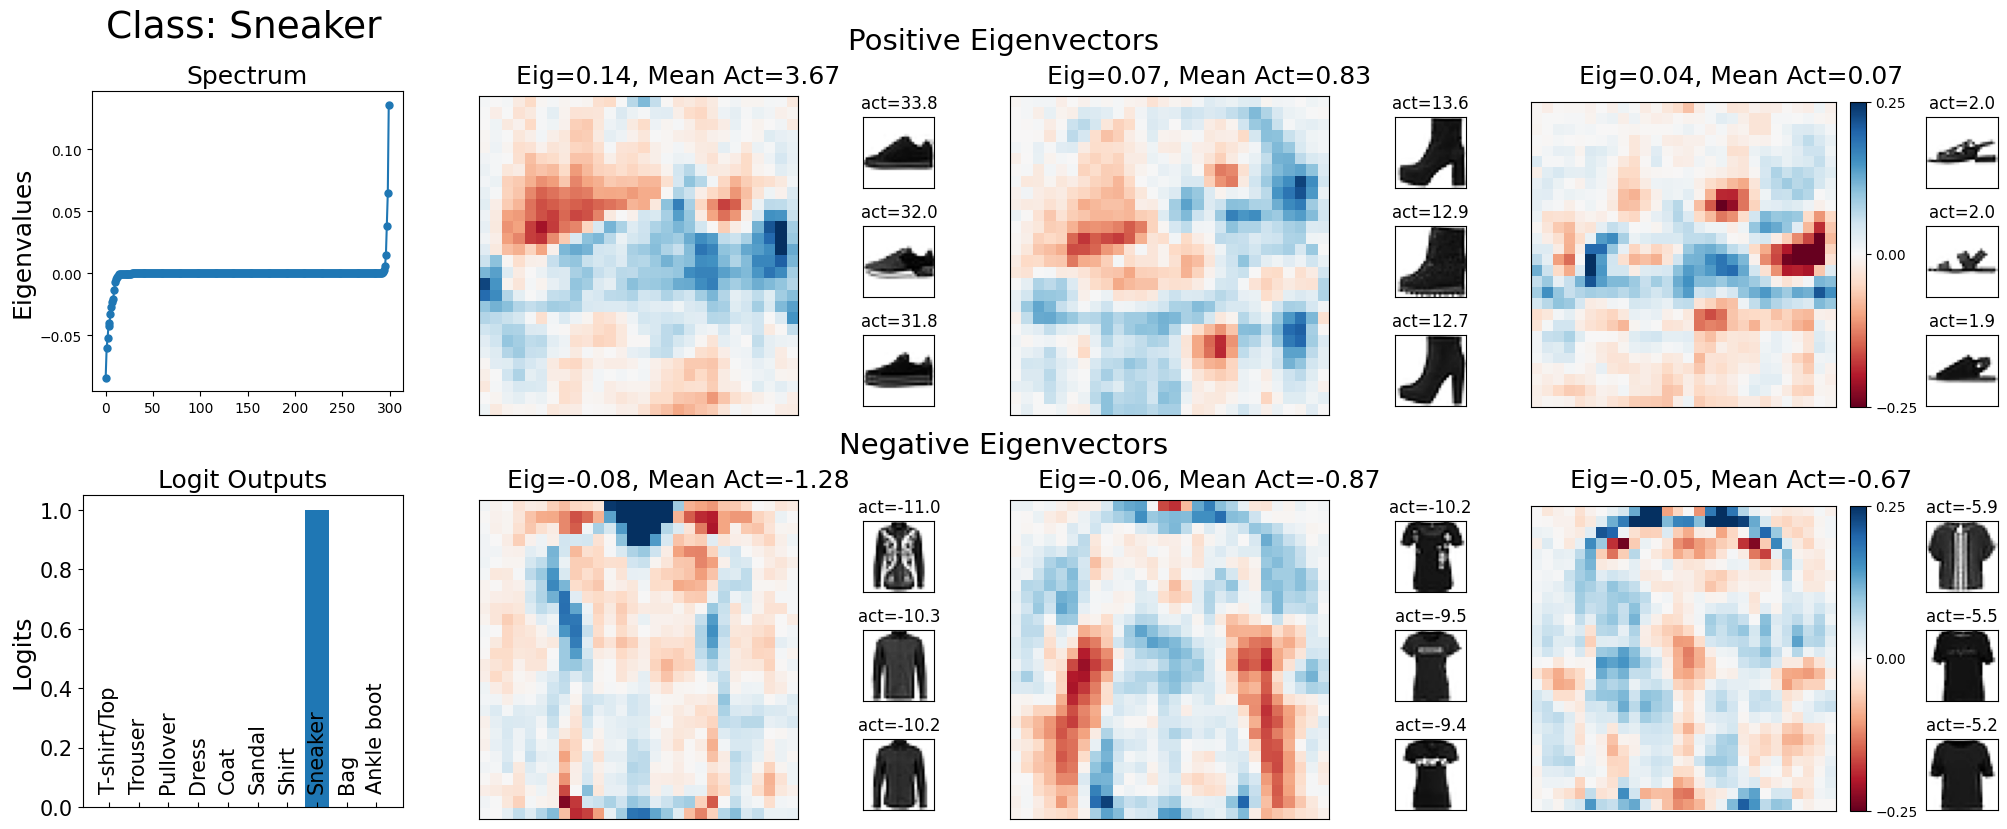

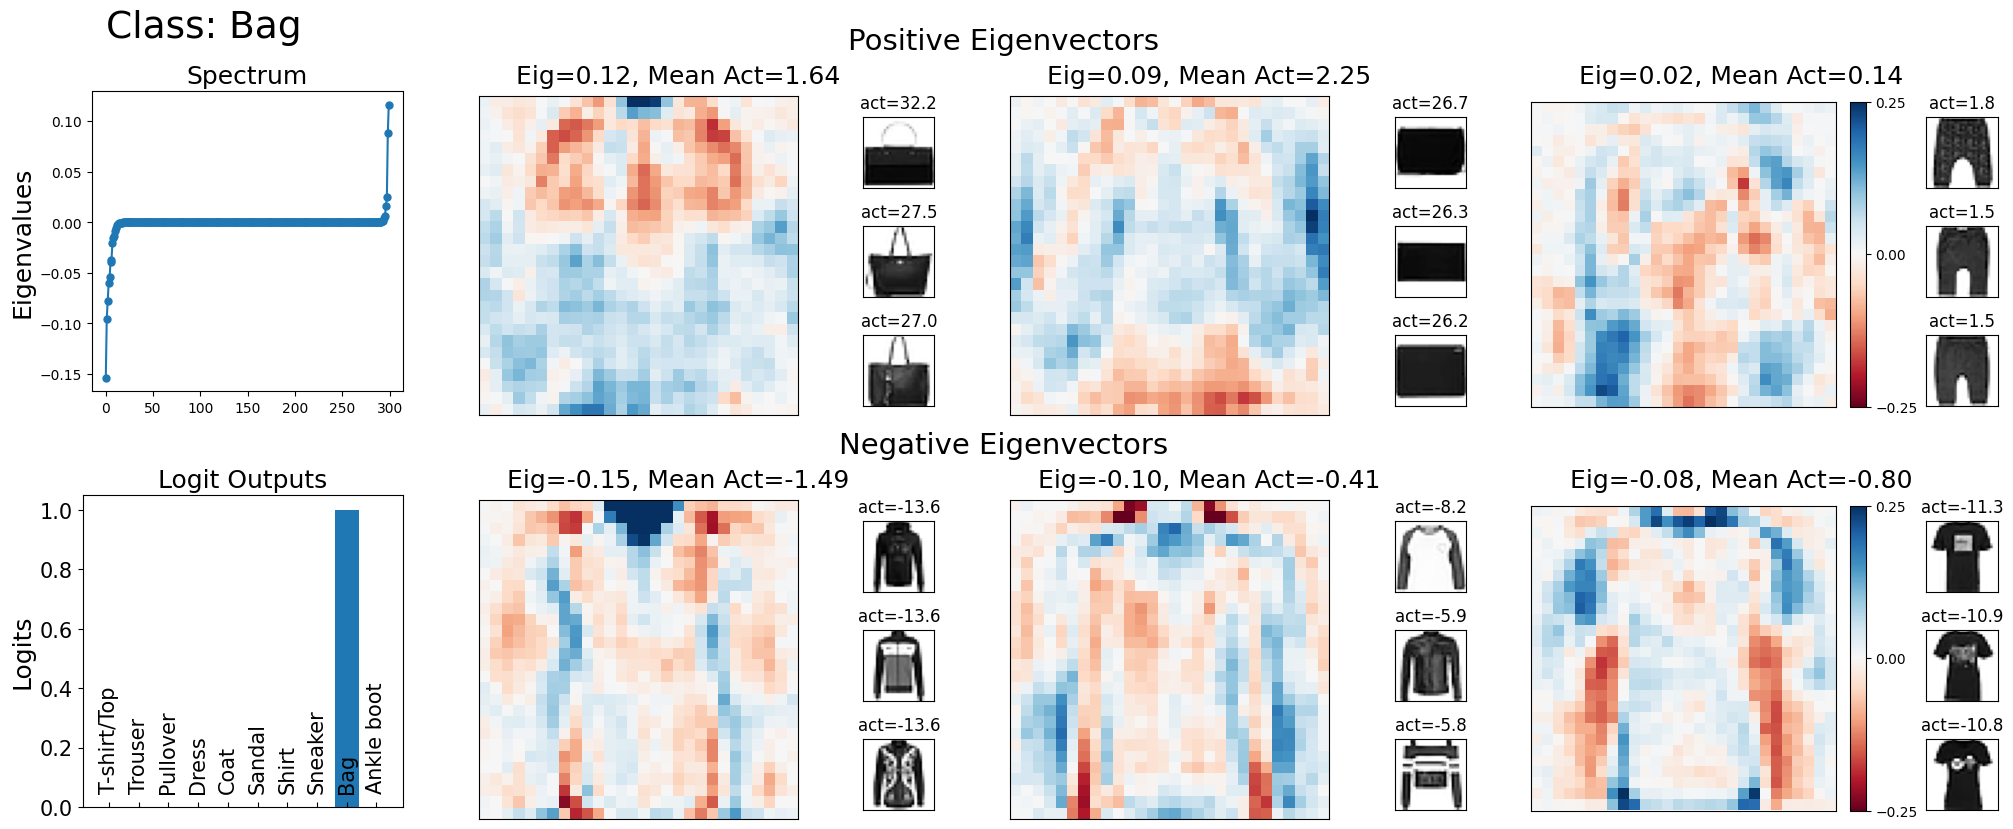

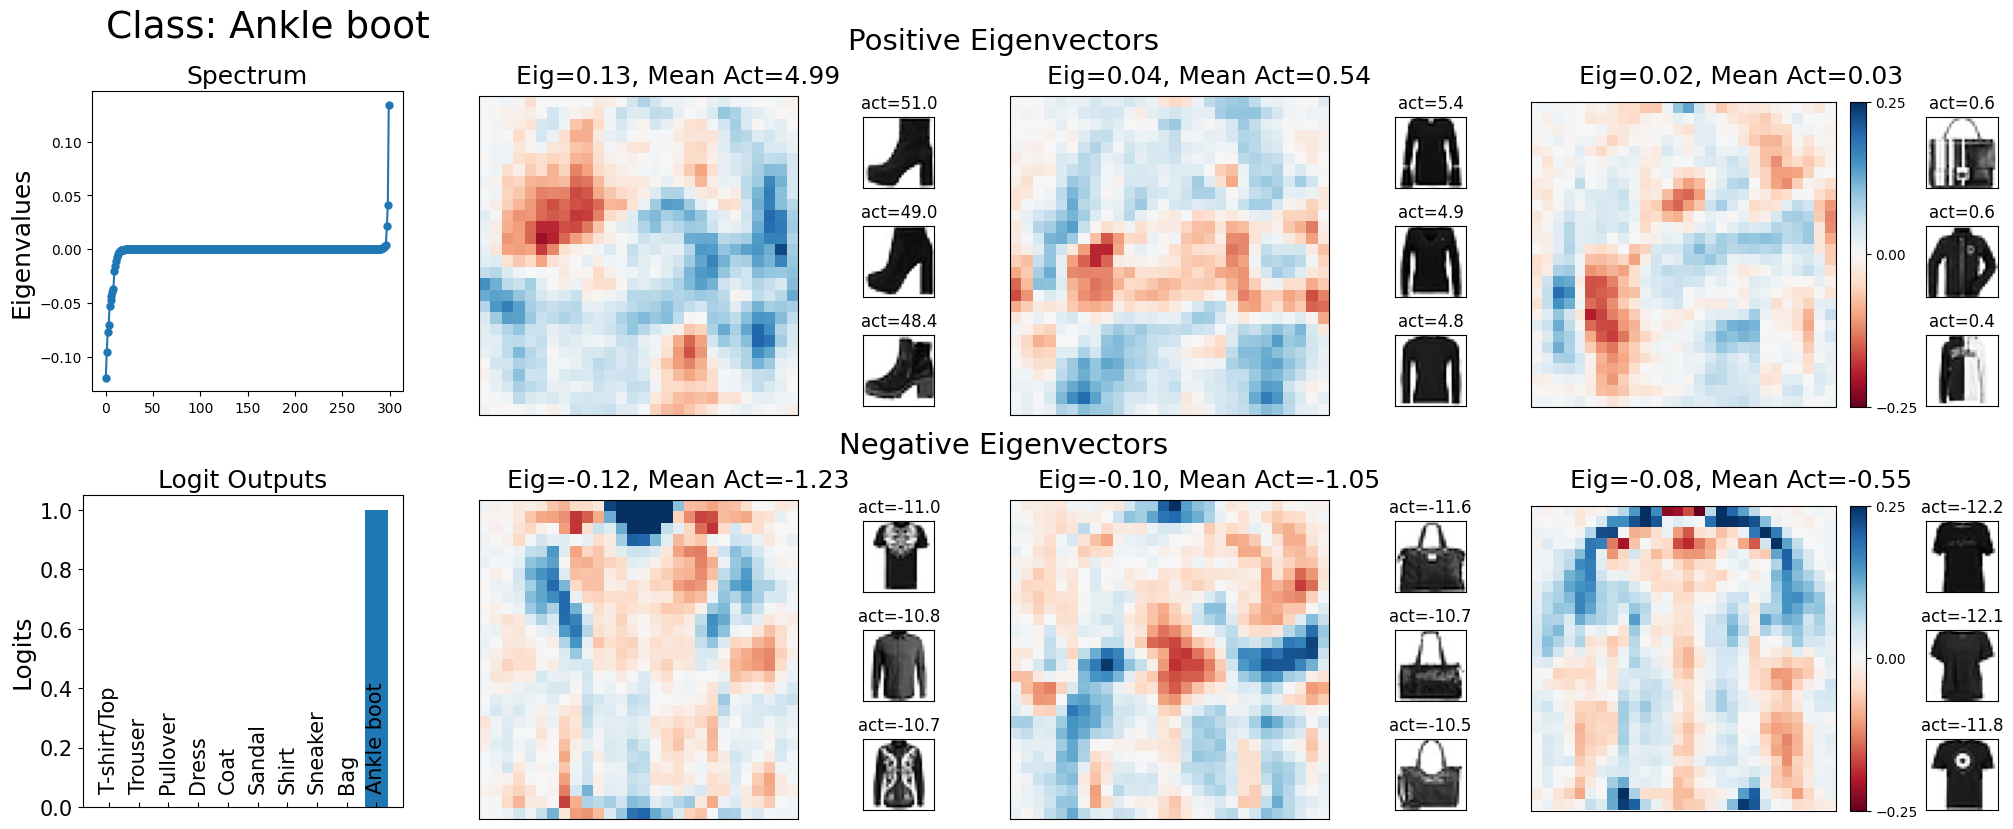

In [ ]:
logits = torch.eye(B_proj.shape[0], B_proj.shape[0])
eig_plotter = EigenvectorPlotter(B_proj, logits, dataset=train_dataset, Embed = W_in)

for i in range(10):
    eig_plotter.plot_component(i, suptitle=f"Class: {DATA_CLASSES[i]}", vmax=0.25, classes = DATA_CLASSES, topk_eigs = 3, sort='eigs')
# plt.tight_layout()

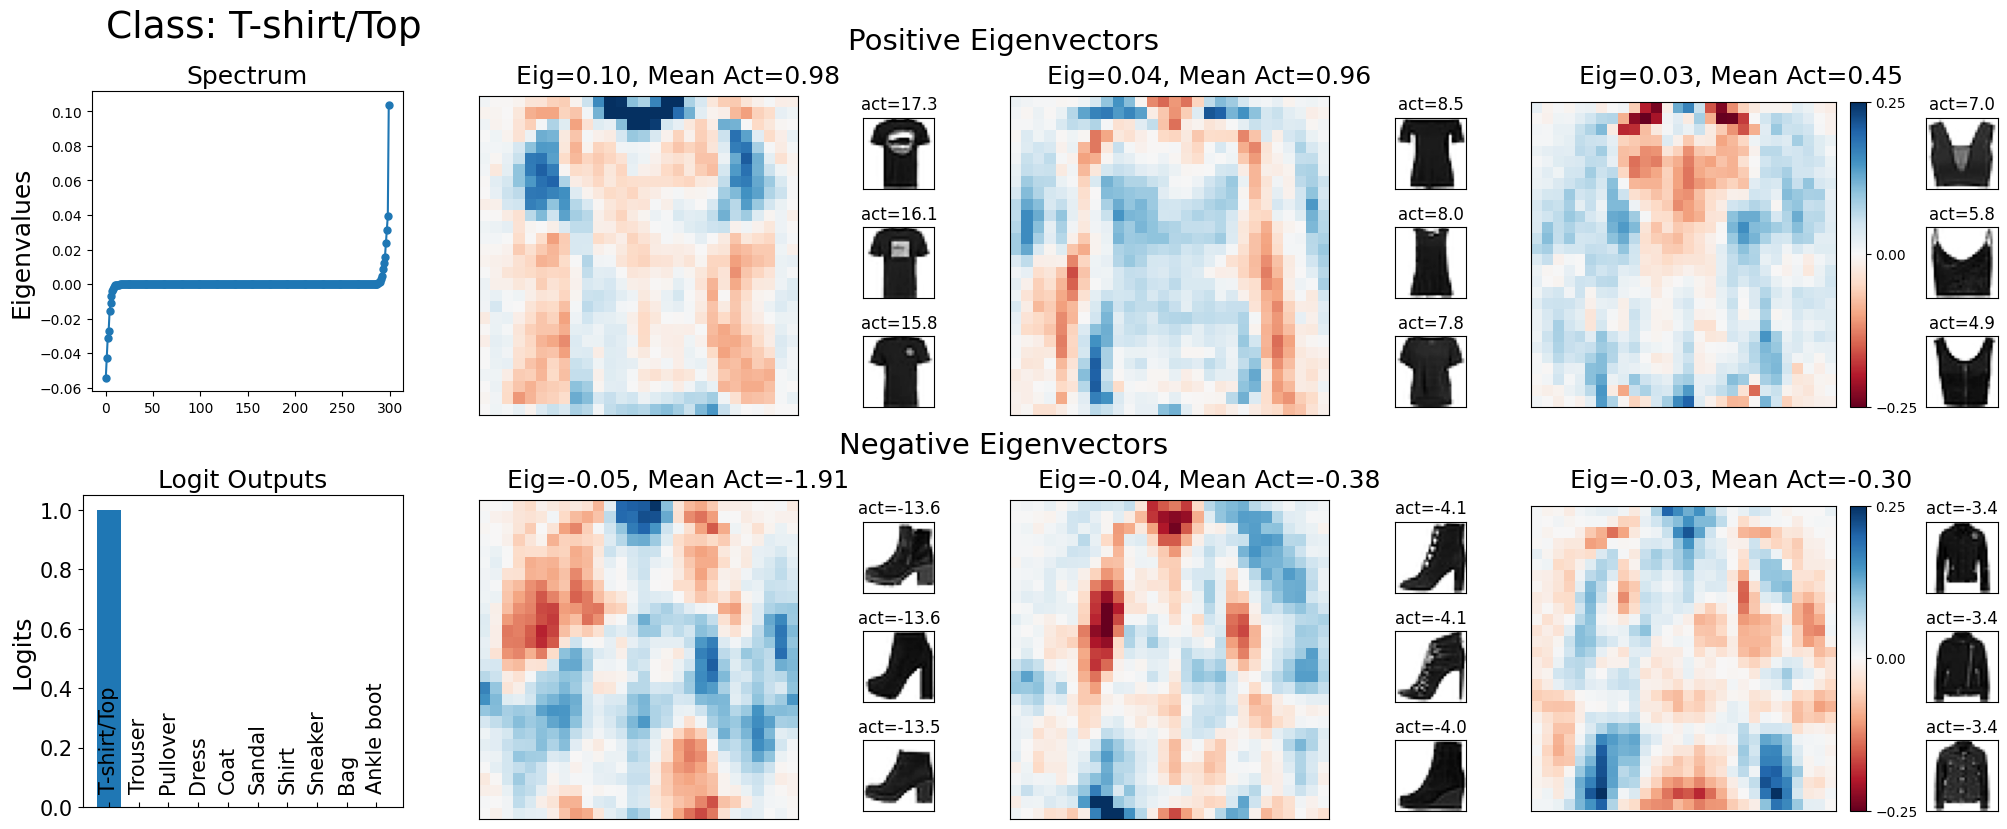

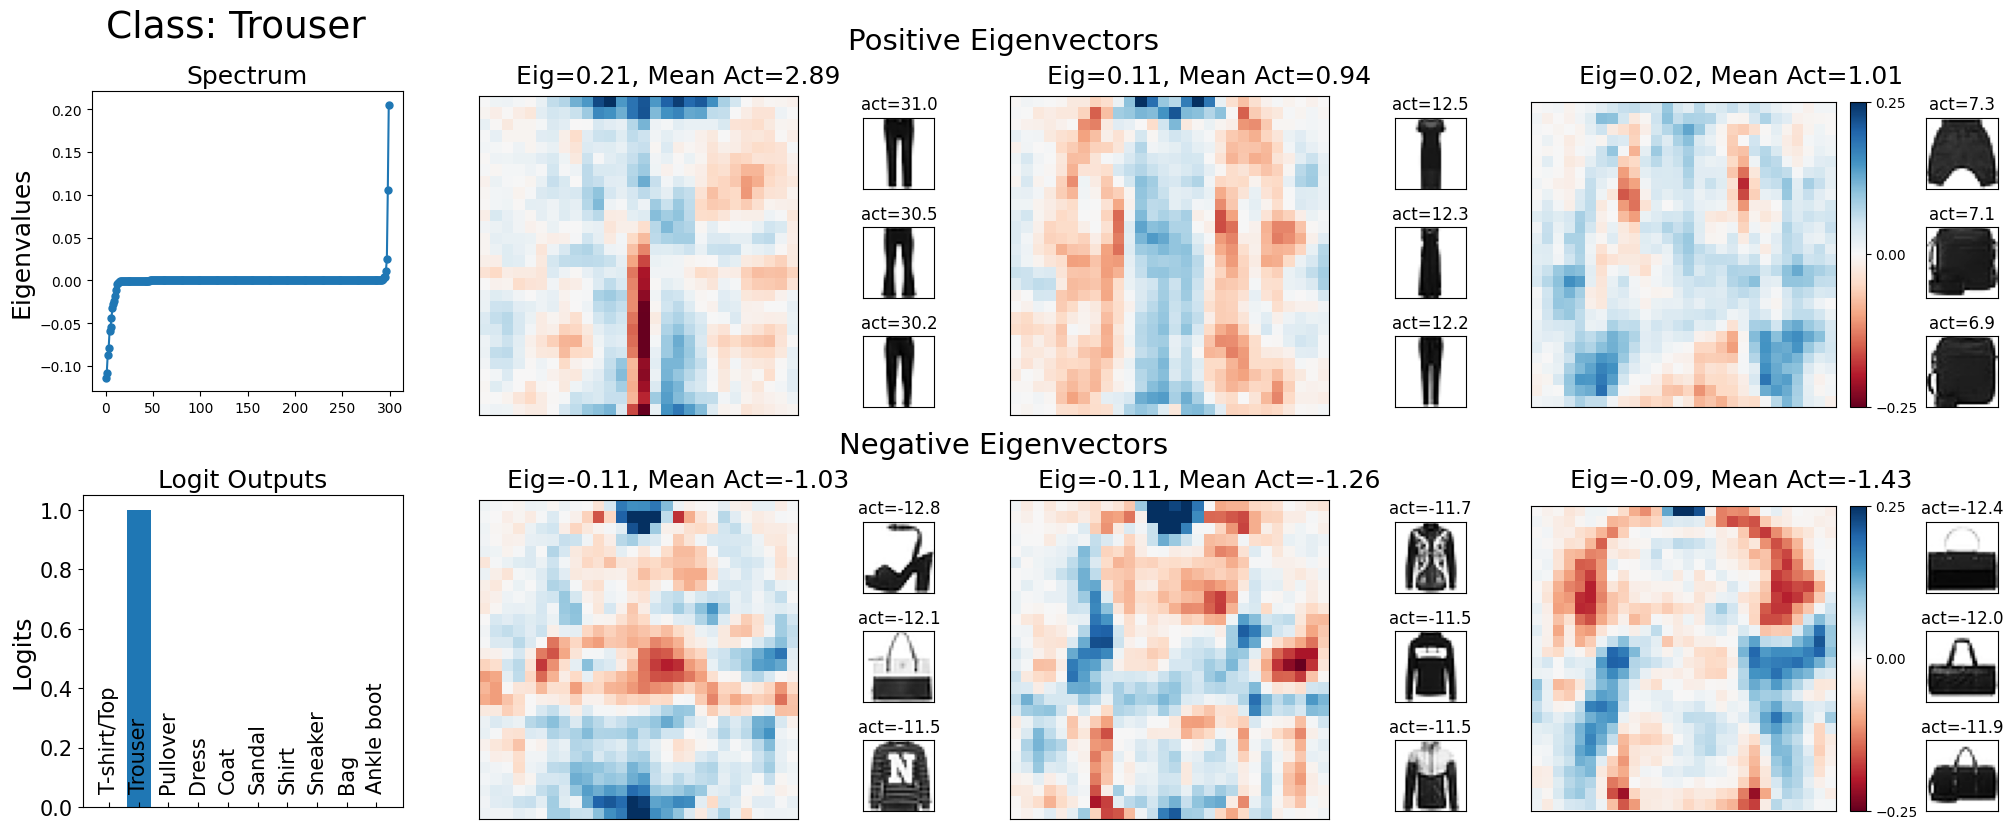

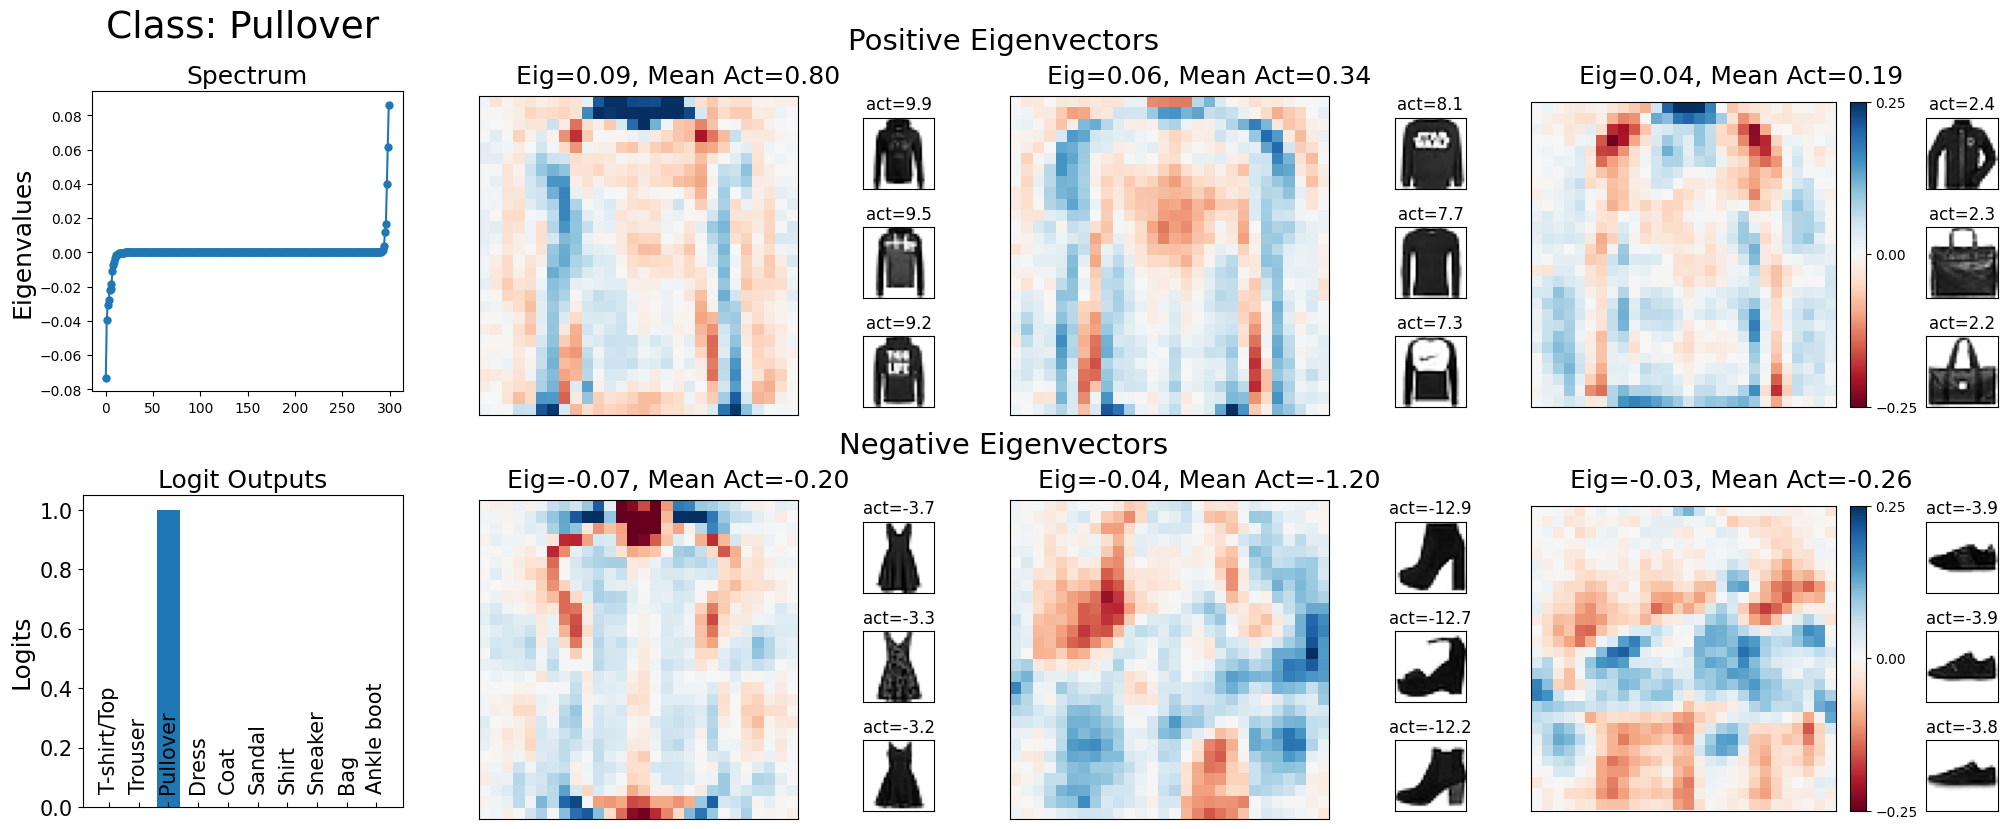

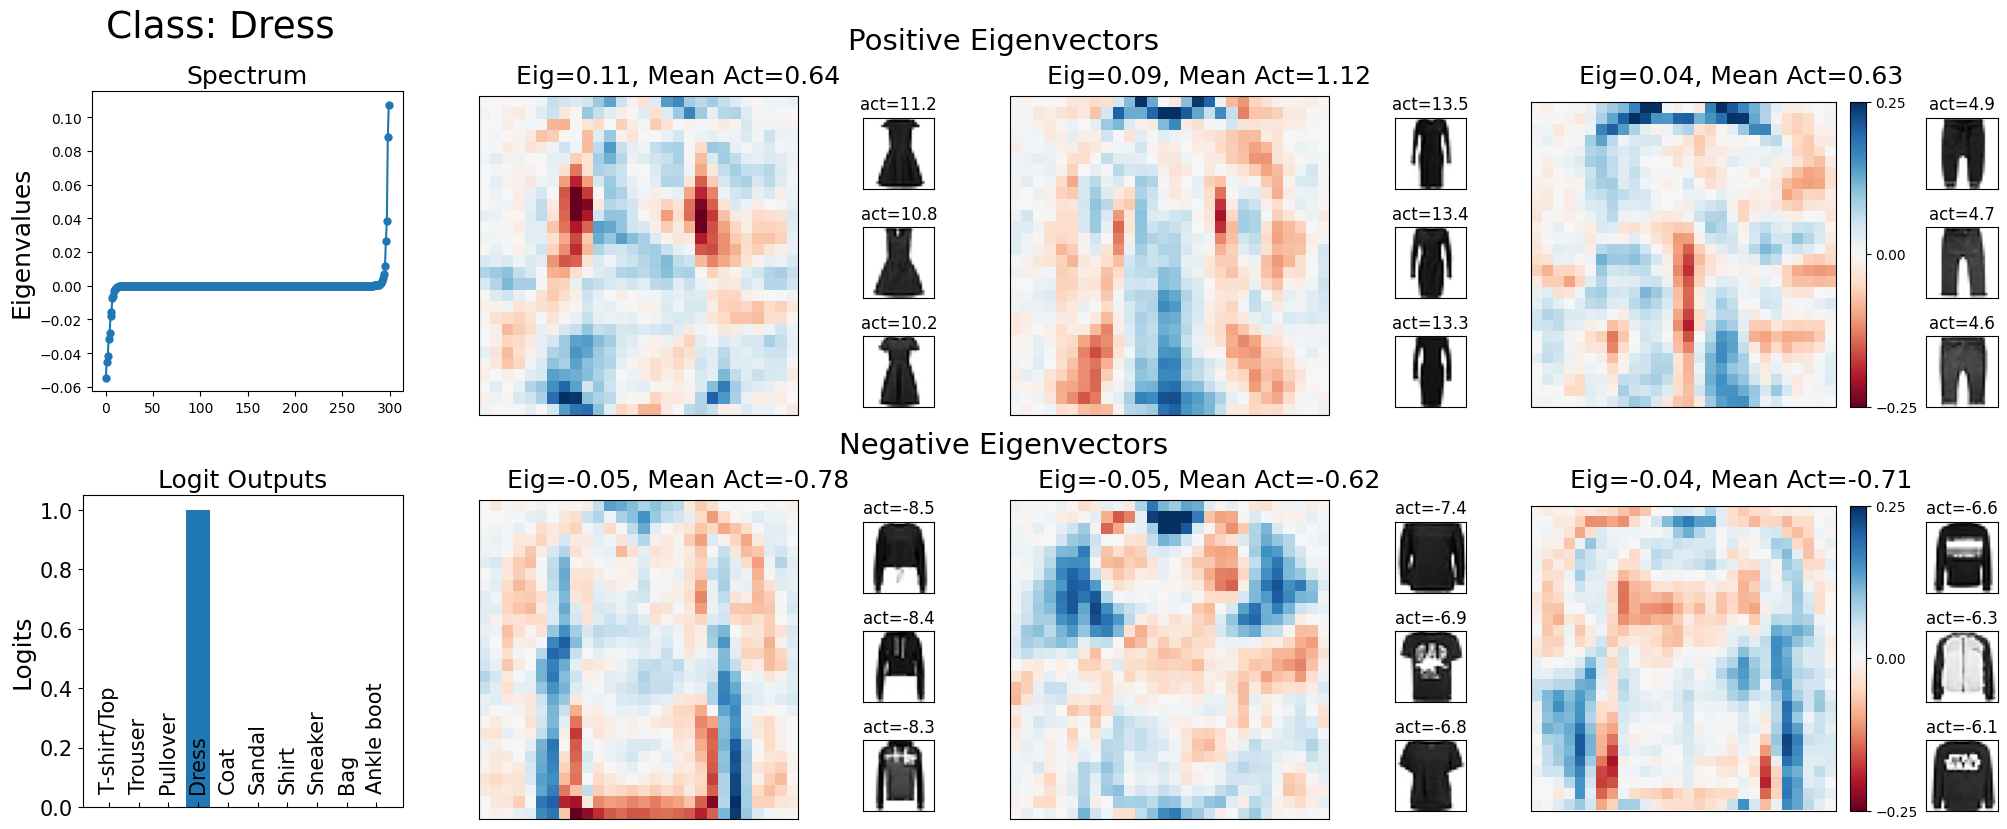

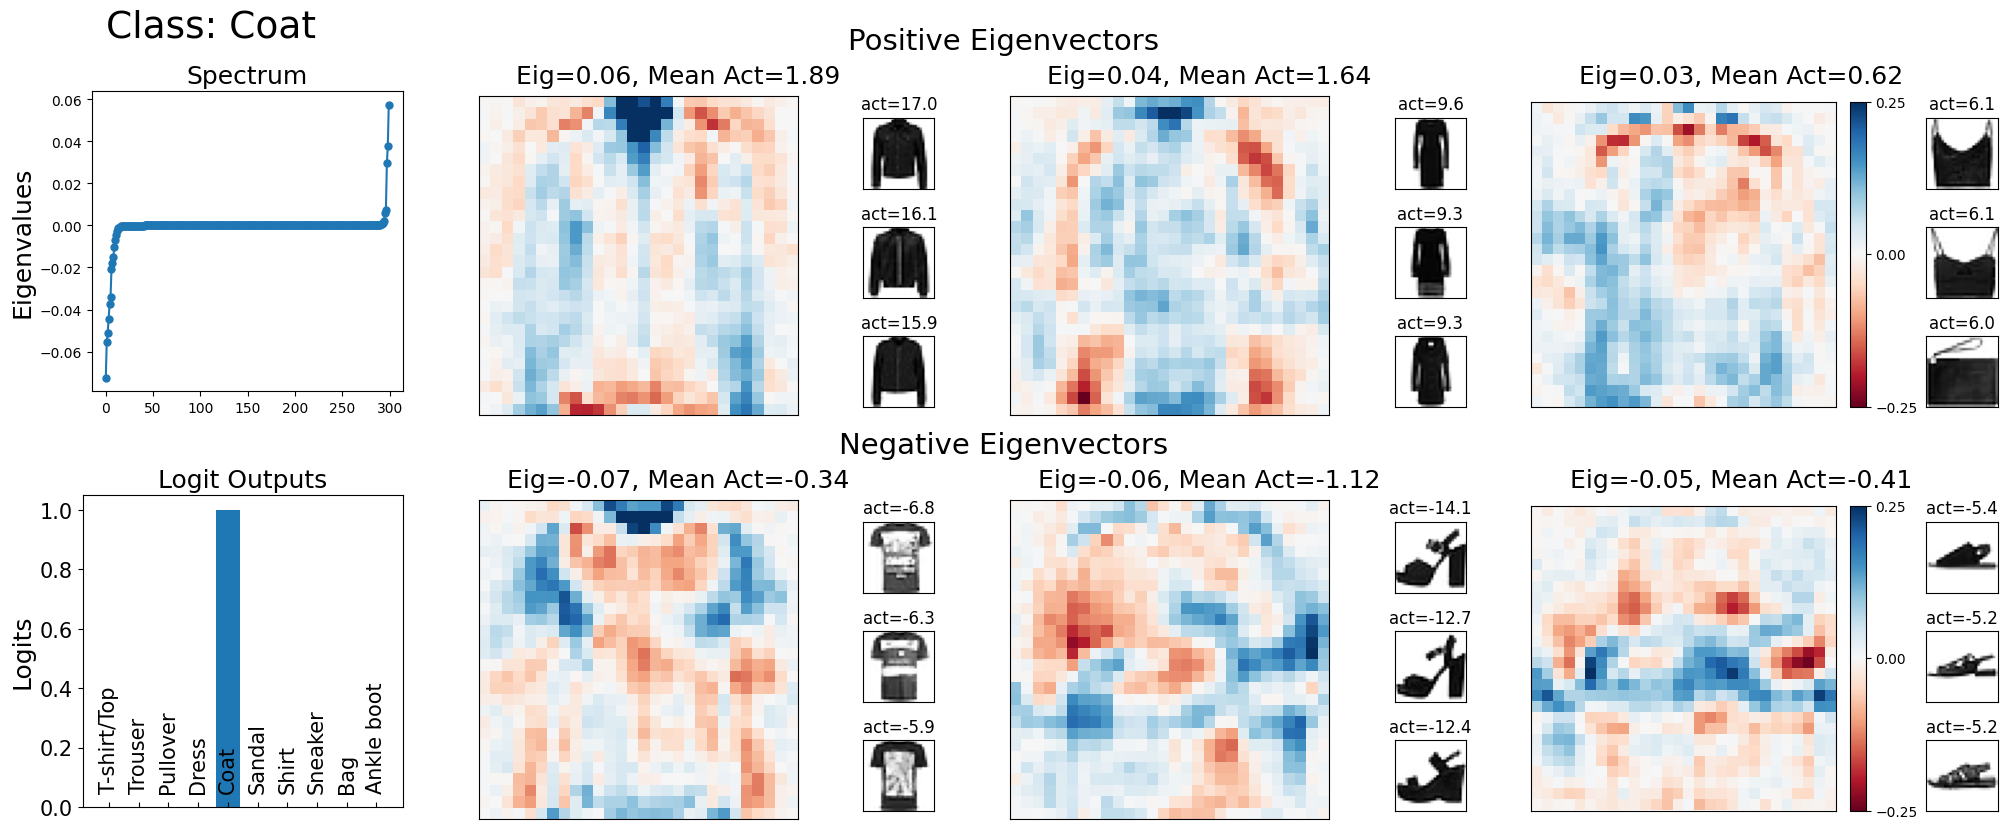

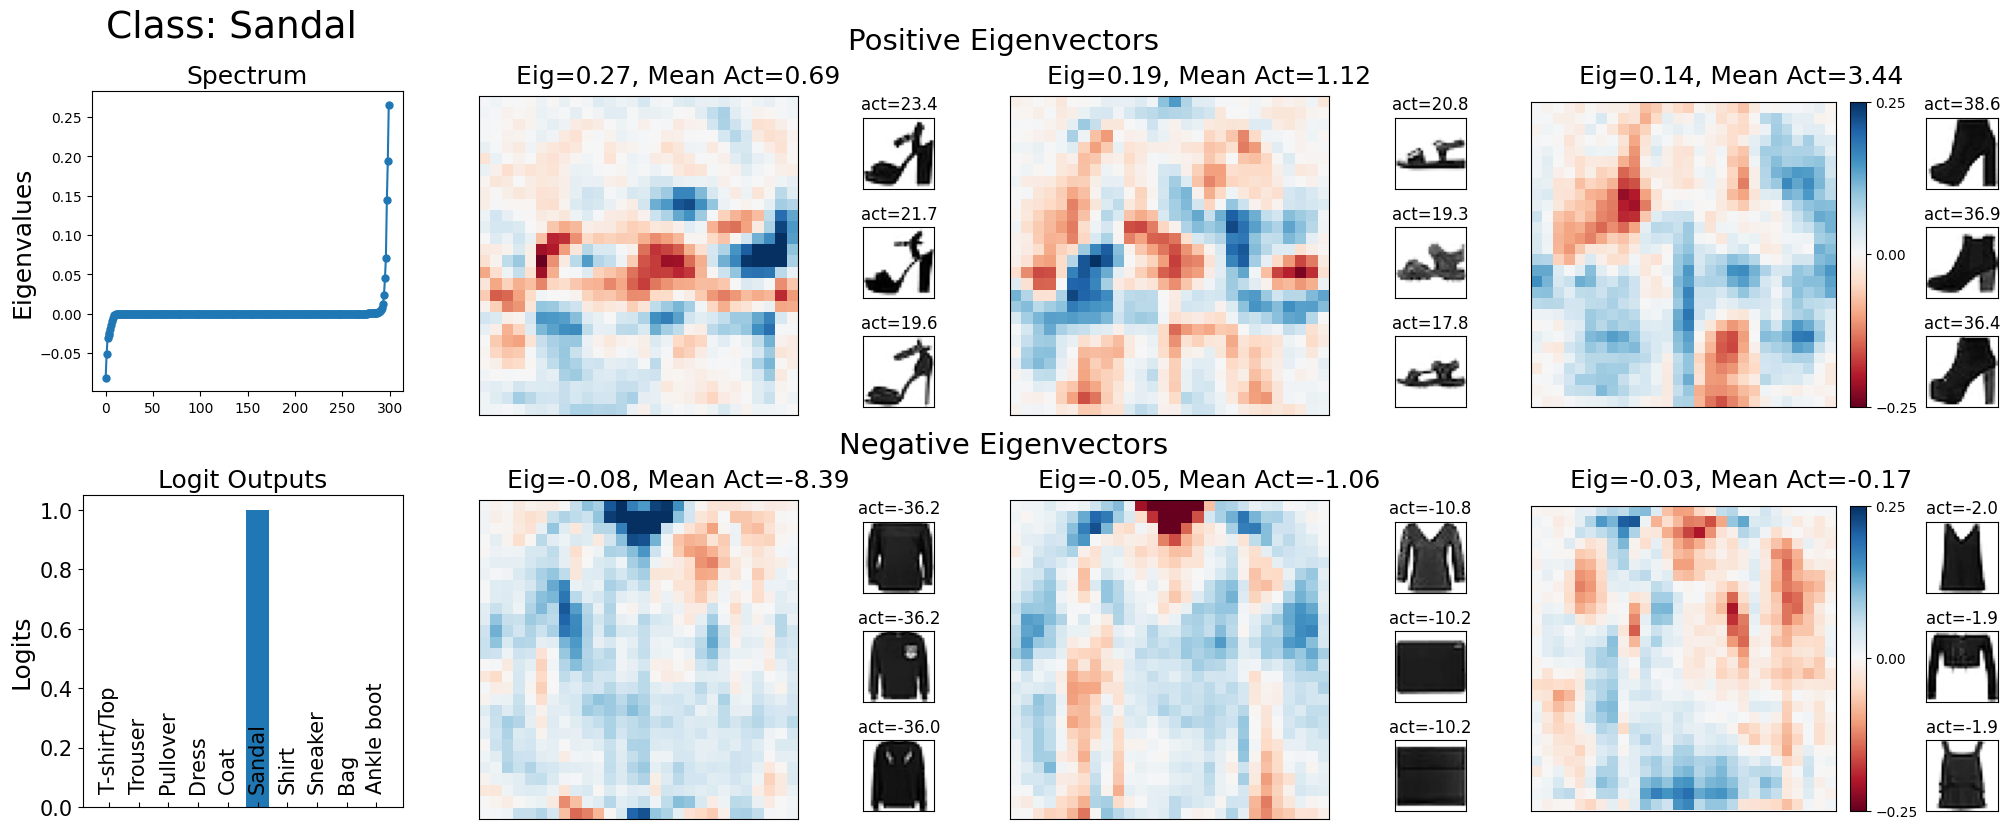

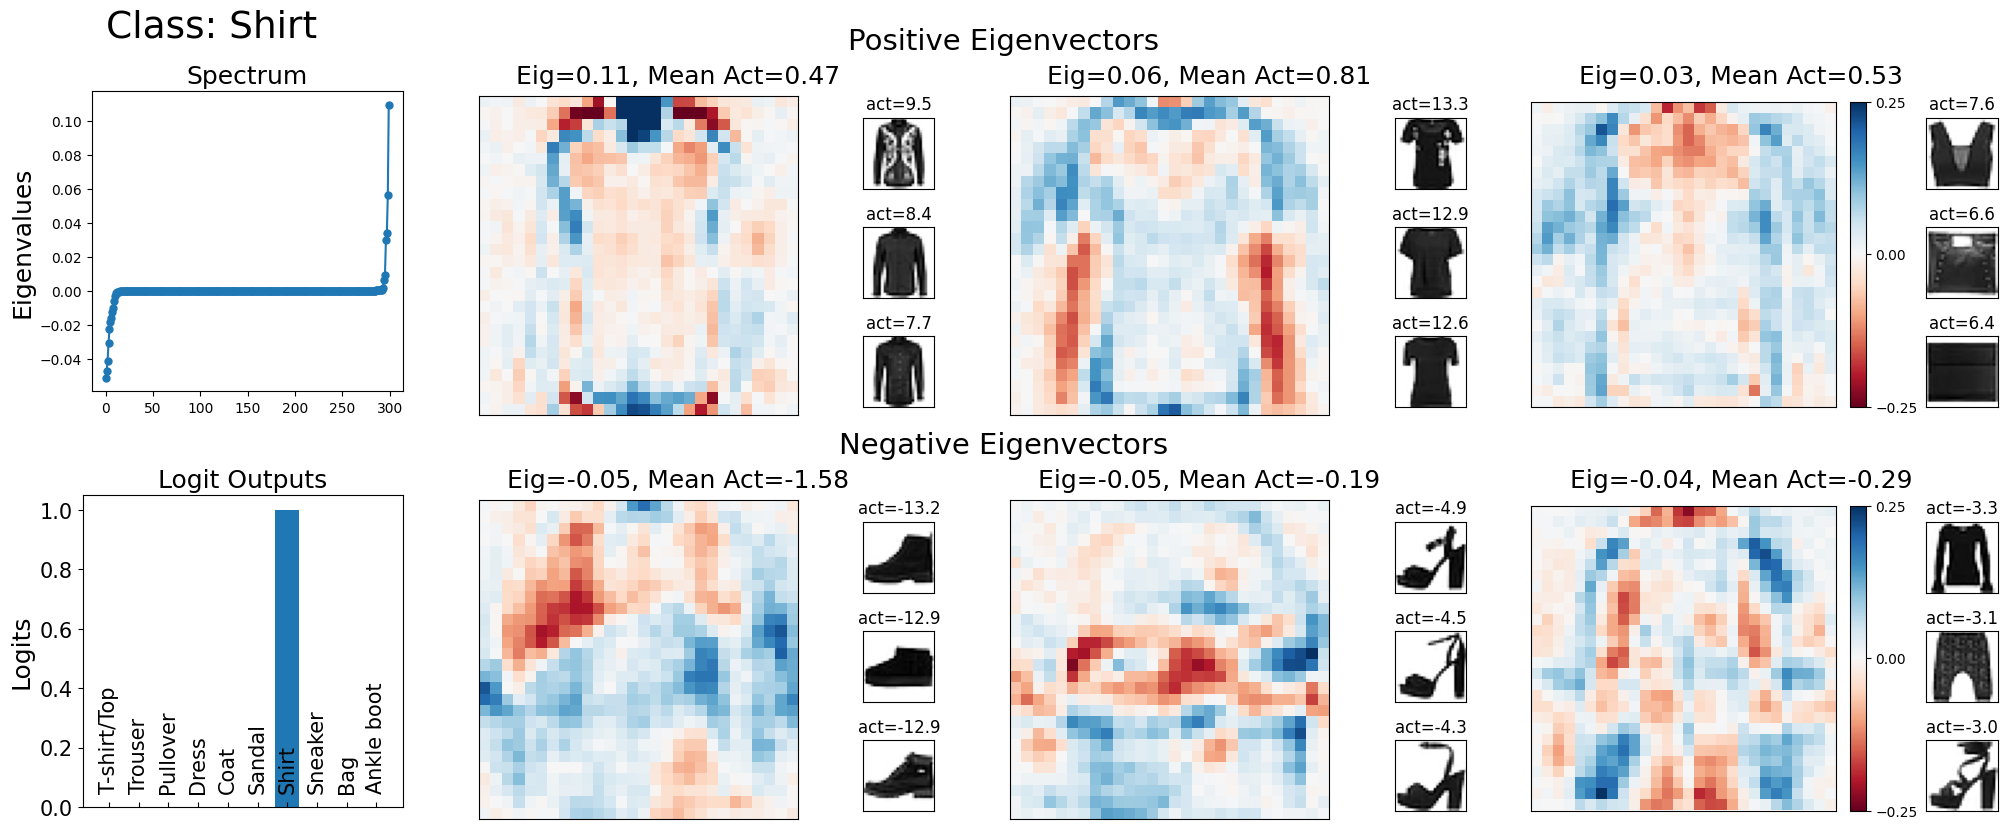

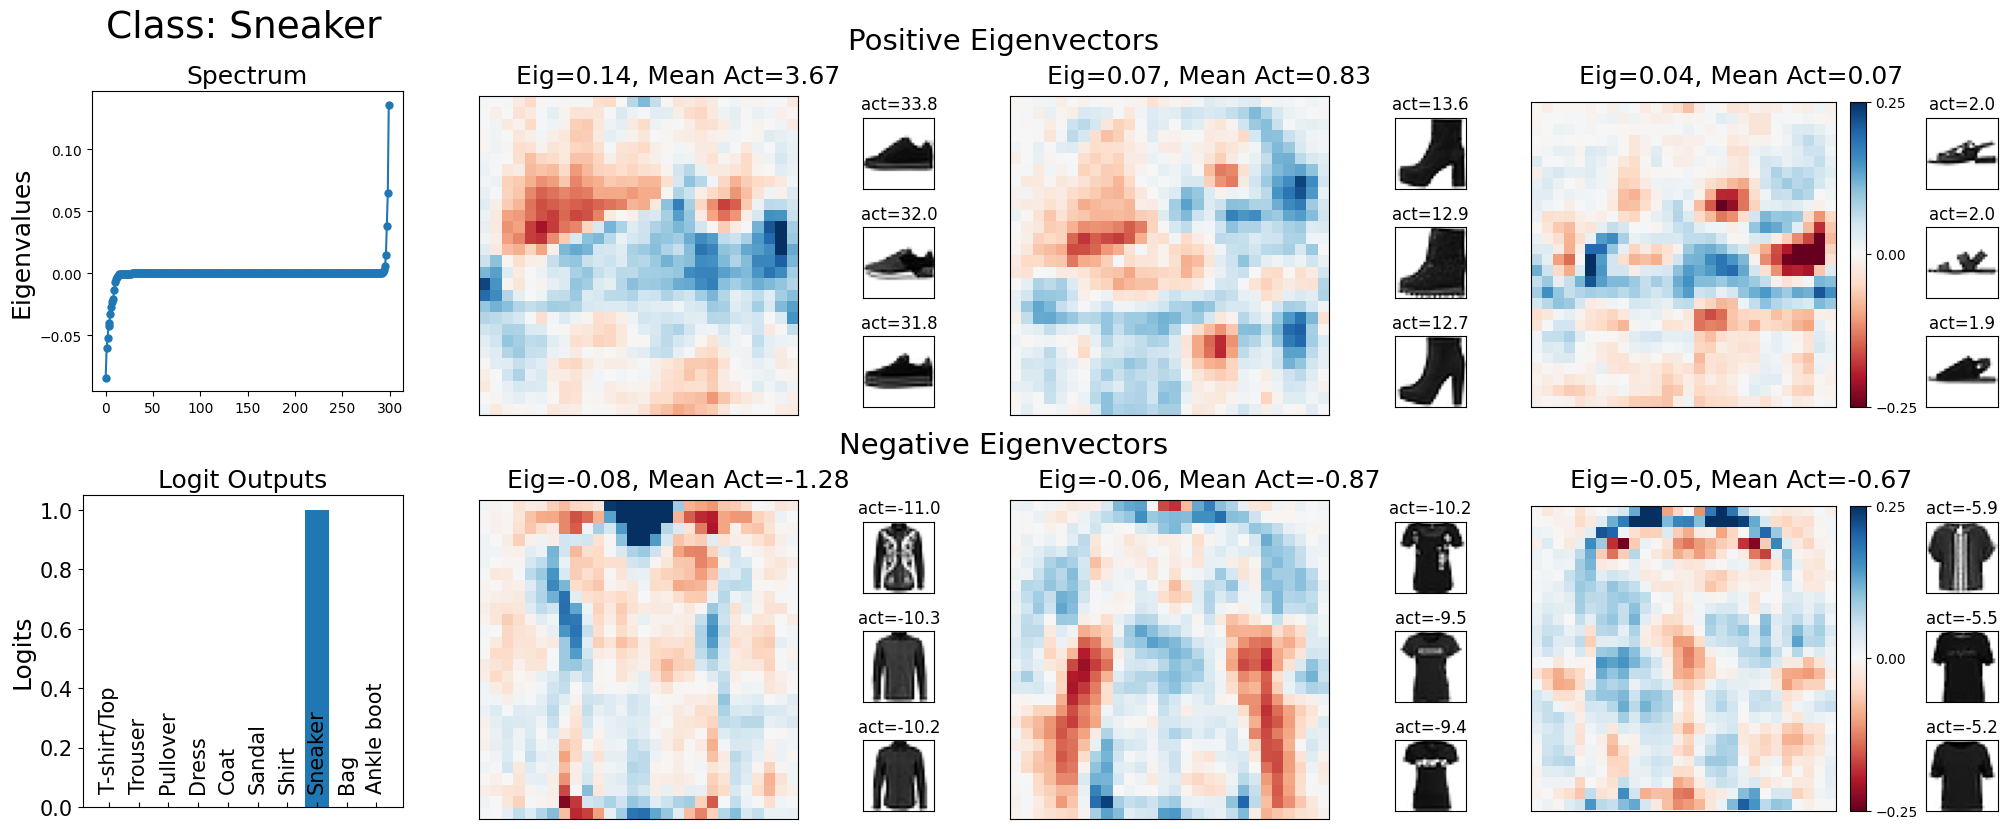

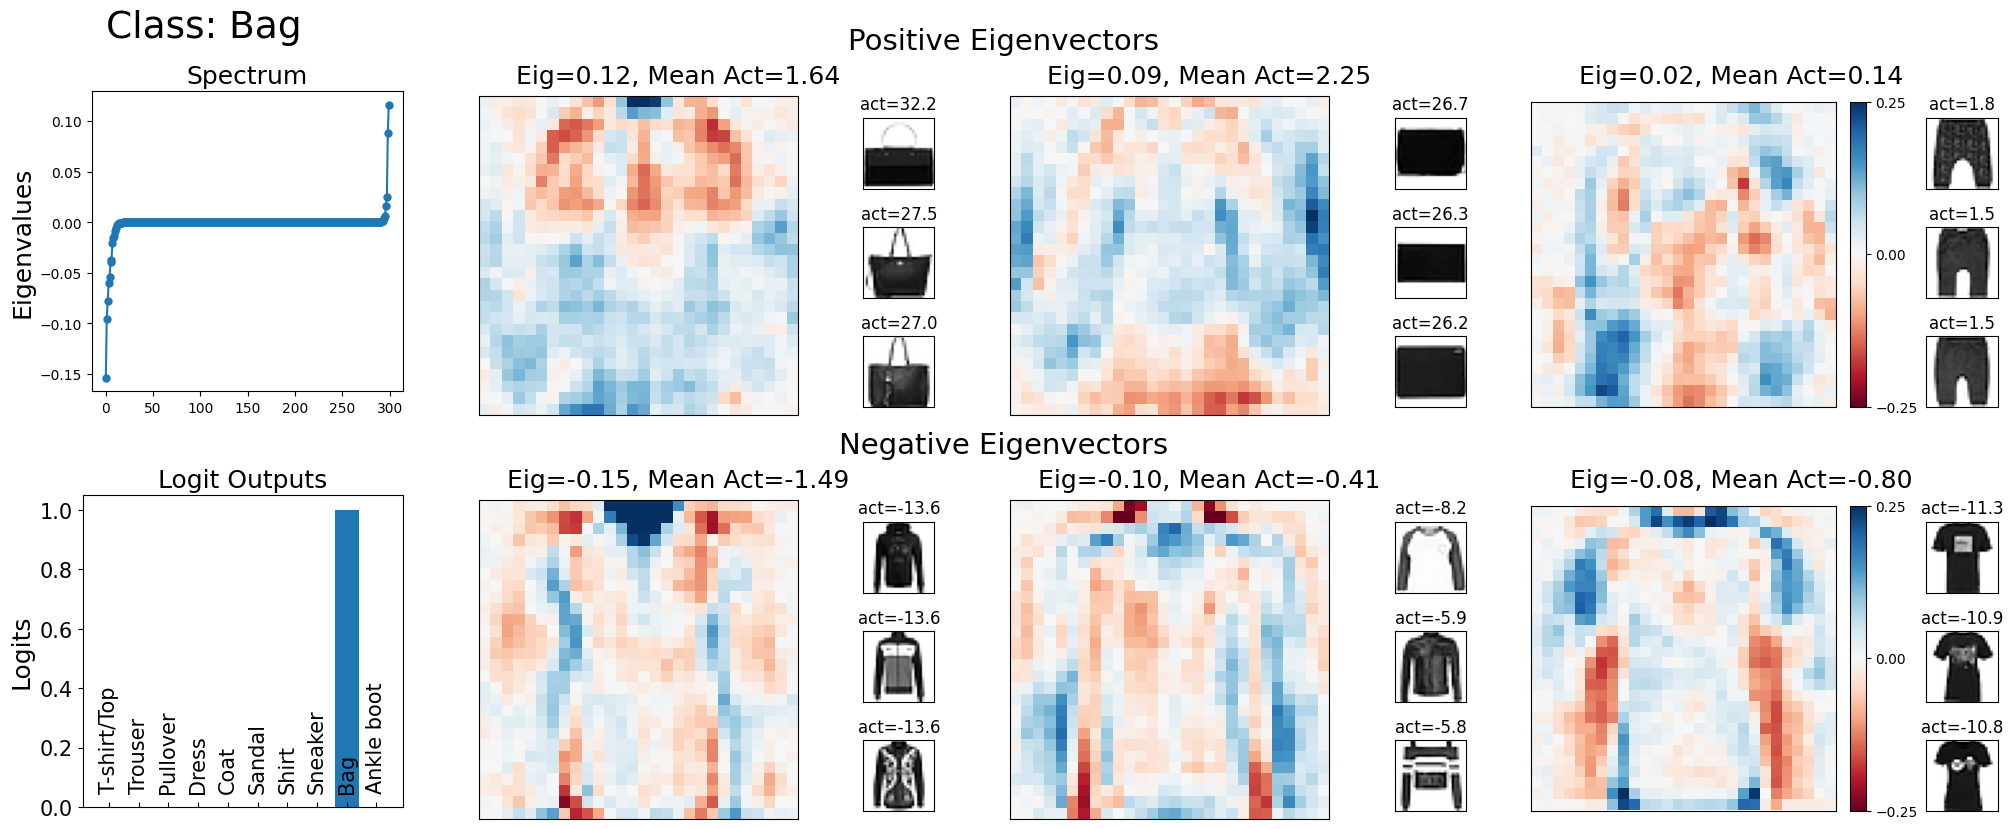

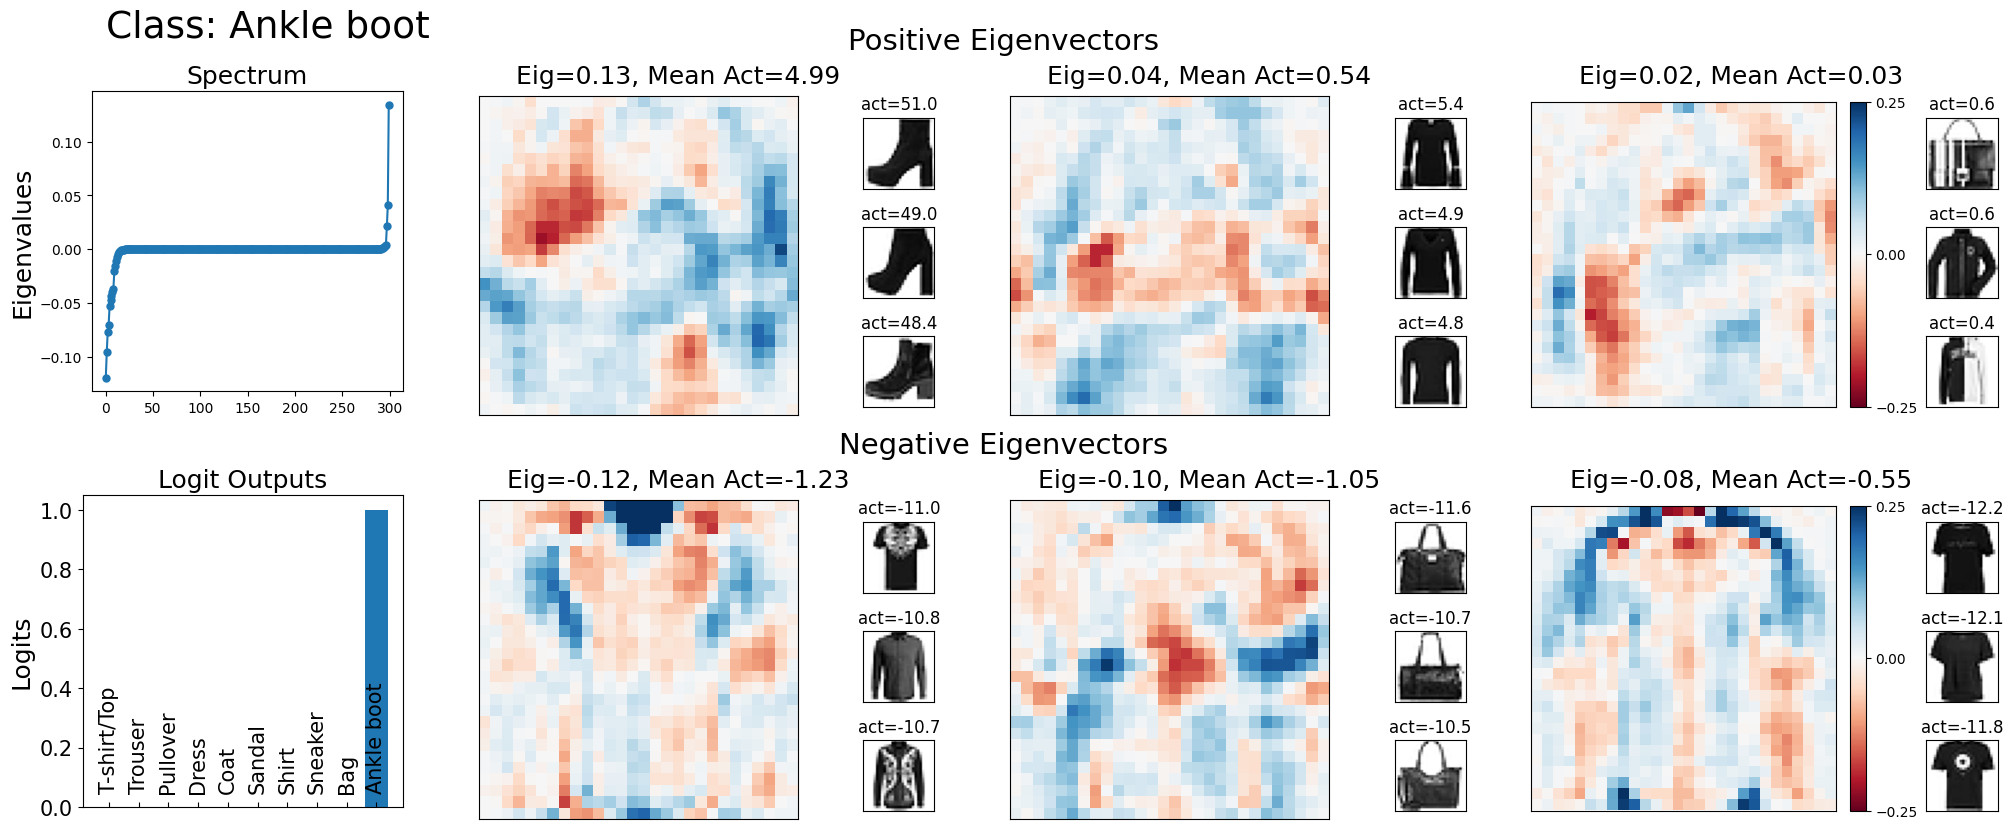

In [ ]:
file_pre = f'/content/drive/MyDrive/AI Safety/Bilinear Features/Noise Regulation/fmnist_noise_reg_weight_decay_and_noise_class_'
logits = torch.eye(B_proj.shape[0], B_proj.shape[0])
eig_plotter = EigenvectorPlotter(B_proj, logits, dataset=train_dataset, Embed = W_in)

for i in range(10):
    eig_plotter.plot_component(i, suptitle=f"Class: {DATA_CLASSES[i]}", vmax=0.25, classes = DATA_CLASSES,
                               topk_eigs = 3, sort='eigs',
                               filename = file_pre+str(i)+'.png')
